# Projet Machine Learning 

Projet réalisé par Sami Guerafi et Thomas Doucet

## Challenge 2020 QRT : Stock Returns

Données issues du Collège de France.
Lien Challenge : https://challengedata.ens.fr/participants/challenges/23/

L'objectif de ce challenge est de prédire le prochain rendement des différents actifs. Les données sont anonymisées (actifs, dates, informations sectorielles, etc.) ne nous permettant pas l'ajout de données financières additionnelles. La métrique d'évaluation imposée par le challenge est l'accuracy. A noter que dans les problèmes financiers, l'accuracy est relativement basse au vu de la compléxité des mouvements boursiers. Une accuracy de l'ordre de 53% représente un très bon résultat. A titre comparatif le benchmark QRT est de 51,3%.

### Quelques informations :
* VOLUME_i correspond au volume relatif aux volumes passés de l'actif et au volume moyen des autres actifs (en j-i).
* RET_i correspond au rendement relatif au marché en j-i.
* Les Dates sont uniques et non ordonnées. (i.e : date N°5 n'est pas la date précédente à la date N°4)
* La variable cible prend la valeur Vraie ou Faux si le rendement de l'actif est supérieur à la médiane des rendements des autres actifs à la même date.

L'objectif de ce challenge est donc de déterminer les actifs qui surperformeront le marché demain. Répondant alors à la question : **Dois-je 
<font color=red>vendre 
<font color=black>ou 
<font color=green>acheter 
<font color=black>cet actif ?**
    
<img src="Fig\Sujet.png" width=60%>
Source : Présentation QRT
    
Afin de répondre à cette problématique nous allons construire différents modèles de Machine Learning nous permettant d'améliorer les résultats obtenues avec nos benchmark (celui de QRT et le nôtre). Le benchmark QRT que nous vous présenterons plus loin met en avant l'importance de construire de nouvelles features. Ils ont décidé de rajouter le rendement moyen de la veille conditionnellement au secteur et on pourra constater que cette feature a la plus grande importance dans le modèle.

**Nos intuitions pour répondre à la problématique :** 
    
* Construction de nouvelles features : statistiques de regroupements sectoriels, moyenne des rendements à différents intervalles de temps, etc... ; 
* Clustering de stock afin d'identifier des actions ayant un comportement proche ;
* Différents traitements des valeurs manquantes ;
* Construction de différents modèles par secteur ;
* Changer de modèles et optimisations des hyper-paramètres.

    

    


In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


In [6]:
#pip install delayed
#pip install imblearn
#pip install termcolor

In [7]:
#Importation des librairies

import sys
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import Pipeline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score,precision_score,roc_auc_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

#from imblearn.pipeline import Pipeline

import time
from termcolor import colored, cprint

## Téléchargement des données


In [8]:
x_train = pd.read_csv('./x_train.csv', index_col='ID')
y_train = pd.read_csv('./y_train.csv', index_col='ID')
test = pd.read_csv('./x_test.csv', index_col='ID')
x_train.head(10)

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.059459,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,0.015413,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,0.008964,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,-0.031769,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.038461,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806
5,0,23,37,12,5,94,0.010938,-0.238878,0.021548,-0.322706,...,0.025915,-0.062753,-0.004552,-0.097196,0.012677,-0.331521,0.032527,0.665084,0.008400,-0.037627
6,0,45,52,18,7,121,0.010602,-0.139011,-0.015338,-0.242468,...,0.007983,-0.273181,-0.003767,0.296727,0.022470,0.158390,-0.005110,-0.219619,0.006428,-0.189815
7,0,59,57,20,8,143,0.001608,0.351362,-0.040863,-0.274854,...,0.016471,0.008281,0.043372,-0.085970,-0.012924,-0.256353,-0.034321,-0.348341,0.011839,-0.811403
8,0,60,46,16,7,108,0.022012,NaN,-0.018519,NaN,...,-0.003232,NaN,0.019781,NaN,-0.028816,NaN,0.000000,NaN,0.007527,-0.333896


**Description des données :**

In [9]:
nb_ligne = x_train.shape[0]
nb_col= x_train.shape[1]
nb_ligneT = test.shape[0]
nb_colT= test.shape[1]

print(' Nombre de lignes base de train: ', nb_ligne)
print(' Nombre de colonnes base de train: ',nb_col,end="\n\n")
print(' Nombre de lignes base de test: ', nb_ligneT)
print(' Nombre de colonnes base de test: ',nb_colT,end="\n\n")  

 Nombre de lignes base de train:  418595
 Nombre de colonnes base de train:  46

 Nombre de lignes base de test:  198429
 Nombre de colonnes base de test:  46



In [10]:
print("Nous disposons des données explicatives suivantes :",end="\n\n")
print(x_train.columns.values,end="\n\n\n")

print("La variable cible est :",end="\n\n")
print(y_train.columns.values,end="\n\n")

print(" ")
y_train.value_counts()

Nous disposons des données explicatives suivantes :

['DATE' 'STOCK' 'INDUSTRY' 'INDUSTRY_GROUP' 'SECTOR' 'SUB_INDUSTRY'
 'RET_1' 'VOLUME_1' 'RET_2' 'VOLUME_2' 'RET_3' 'VOLUME_3' 'RET_4'
 'VOLUME_4' 'RET_5' 'VOLUME_5' 'RET_6' 'VOLUME_6' 'RET_7' 'VOLUME_7'
 'RET_8' 'VOLUME_8' 'RET_9' 'VOLUME_9' 'RET_10' 'VOLUME_10' 'RET_11'
 'VOLUME_11' 'RET_12' 'VOLUME_12' 'RET_13' 'VOLUME_13' 'RET_14'
 'VOLUME_14' 'RET_15' 'VOLUME_15' 'RET_16' 'VOLUME_16' 'RET_17'
 'VOLUME_17' 'RET_18' 'VOLUME_18' 'RET_19' 'VOLUME_19' 'RET_20'
 'VOLUME_20']


La variable cible est :

['RET']

 


RET  
False    209749
True     208846
dtype: int64

In [11]:
#Nous concaténons x_train et y_train
train=pd.concat([x_train,y_train],axis=1)

print(" Sur la base de train nous avons pour les variables qualitatives :",end="\n\n")
Descr=['DATE','STOCK','INDUSTRY','INDUSTRY_GROUP','SECTOR','SUB_INDUSTRY']
for i in range(len(Descr)):
    print (" Nombre de " + Descr[i] + " :",len(train[Descr[i]].unique()))

 Sur la base de train nous avons pour les variables qualitatives :

 Nombre de DATE : 156
 Nombre de STOCK : 5350
 Nombre de INDUSTRY : 72
 Nombre de INDUSTRY_GROUP : 26
 Nombre de SECTOR : 12
 Nombre de SUB_INDUSTRY : 175


Ci-dessous un graphique de la hiérarchie des groupes sectoriels :

<img src="Fig\Sector.png" width=40%>
Source : Présentation Challenge QRT


In [12]:
# Les valeurs manquantes :

NA=train.isna().sum()
print("Variables complètes (sans valeurs manquantes) :")
print(NA[NA==0].index.values)
print("Il ne manque aucune valeur 'qualitative'. Les dates sont toutes présentes et la valeur cible est complète.",end="\n\n")

print("Pourcentage de valeurs manquantes par categories :")
print(NA[NA>0]/train.shape[0],end="\n\n\n")
print("On peut noter qu'il y a environ 0.5% de rendement manquant alors qu'il y a environ 16% de #NA pour les Volumes")

Variables complètes (sans valeurs manquantes) :
['DATE' 'STOCK' 'INDUSTRY' 'INDUSTRY_GROUP' 'SECTOR' 'SUB_INDUSTRY' 'RET']
Il ne manque aucune valeur 'qualitative'. Les dates sont toutes présentes et la valeur cible est complète.

Pourcentage de valeurs manquantes par categories :
RET_1        0.005636
VOLUME_1     0.155341
RET_2        0.005889
VOLUME_2     0.158592
RET_3        0.005989
VOLUME_3     0.162016
RET_4        0.006077
VOLUME_4     0.169608
RET_5        0.006173
VOLUME_5     0.178437
RET_6        0.006204
VOLUME_6     0.178488
RET_7        0.006175
VOLUME_7     0.176431
RET_8        0.006266
VOLUME_8     0.176538
RET_9        0.006407
VOLUME_9     0.175105
RET_10       0.006431
VOLUME_10    0.175122
RET_11       0.007074
VOLUME_11    0.172064
RET_12       0.007611
VOLUME_12    0.149364
RET_13       0.008027
VOLUME_13    0.140967
RET_14       0.010542
VOLUME_14    0.145556
RET_15       0.011921
VOLUME_15    0.158561
RET_16       0.012614
VOLUME_16    0.160685
RET_17       0

Au vu de la relativité des rendements et volumes, nous déciderons de remplacer les valeurs manquantes par des 0

<function matplotlib.pyplot.show(close=None, block=None)>

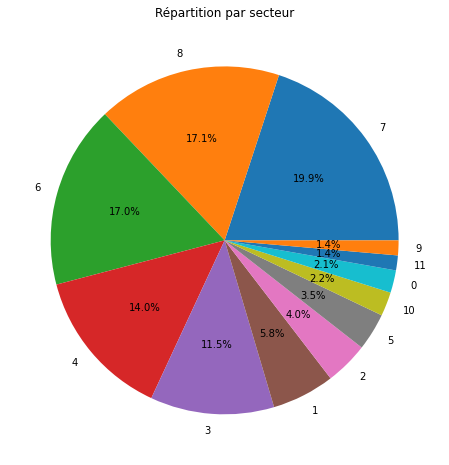

In [13]:
#Répartition des stocks dans les secteurs

rep_sec=train[Descr]
indextest=rep_sec['STOCK'].drop_duplicates().index
indextest

plt.figure(figsize=(10, 8))
rep_sec=rep_sec.loc[indextest]
plt.pie(rep_sec['SECTOR'].value_counts(),labels=rep_sec['SECTOR'].value_counts().index,autopct='%1.1f%%')
plt.title("Répartition par secteur")
plt.show

 Nombre de stock : 5350


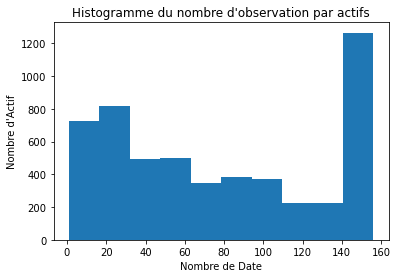

 Nombre d'actif présent à toutes les dates : 1077  (soit  20.13 % du total des actifs)


In [14]:
#Nombre d'observation par stock : déterminer le nombre de date où un actif est présent.

NbDate=len(train['DATE'].unique())
print( ' Nombre de stock :',len(train['STOCK'].unique()))
NbrObs_stock=train['STOCK'].value_counts()
plt.hist(NbrObs_stock)
plt.title("Histogramme du nombre d'observation par actifs")
plt.xlabel("Nombre de Date")
plt.ylabel("Nombre d'Actif")
plt.show()
print( " Nombre d'actif présent à toutes les dates :",len(NbrObs_stock[NbrObs_stock==NbDate]),\
      " (soit ",
      round(len(NbrObs_stock[NbrObs_stock==NbDate])/len(train['STOCK'].unique())*100,2), "% du total des actifs)")


## Mise en place du Benchmark QRT

Génération de nouvelles features : Ici Moyenne du rendement de la veille par secteur


**Pour la mise en place du Benchmark :** 
ils ont décidé d'utiliser uniquement les rendements et volumes des 5 derniers jours ainsi que la feature du rendement par secteur de la veille.

**Modèle utilisé :**
Une Forêt aléatoire comprenant 500 arbres avec une profondeur max de 8. Les valeurs manquantes sont remplacés par des 0 et un Kfold est utilisé.

In [15]:
# Création de la nouvelle feature
new_features = []
# Conditional aggregated features
shifts = [1]  # Choose some different shifts
statistics = ['mean']  # the type of stat
gb_features = ['SECTOR', 'DATE']
target_feature = 'RET'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}_{shift}'
        new_features.append(name)
        for data in [train, test]:
            data[name] = data.groupby(gb_features)[feat].transform(stat)

In [16]:
target = 'RET' # Variable Cible

n_shifts = 5  #Historique des Rdts et Volumes
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features += new_features  # Ajout de la feature conditionnelle
train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,RET_1_SECTOR_DATE_mean
ID,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,0.009178
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,NaN,NaN,NaN,NaN,NaN,0.006477
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455,0.013449
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,0.017253
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,0.006241


In [17]:
X_train = train[features]
y_train = train[target]

# Paramètres de la forêt aléatoire du Benchmark QRT

rf_params = {
    'n_estimators': 500, #Nombre d'arbre
    'max_depth': 2**3, #Profondeur maximale de l'arbre
    'random_state': 0, #Figer les résultats
    'n_jobs': -1 #Améliorer le temps d'exécution
}

# Validation croisée

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

start_time = time.time() #Récupérer le temps d'éxécution

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    
    #Reconstitution 
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
QRTscore=mean #On stock le résultat du score QRT
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')
print('-----------------------------------------------------')
cprint("--------- %s seconds ---------" % (round(time.time() - start_time,2)), 'red')
print('-----------------------------------------------------')

Fold 1 - Accuracy: 51.87%
Fold 2 - Accuracy: 50.65%
Fold 3 - Accuracy: 51.11%
Fold 4 - Accuracy: 52.10%
Accuracy: 51.43% [50.85 ; 52.02] (+- 0.58)
-----------------------------------------------------
--------- 576.66 seconds ---------
-----------------------------------------------------


<AxesSubplot:>

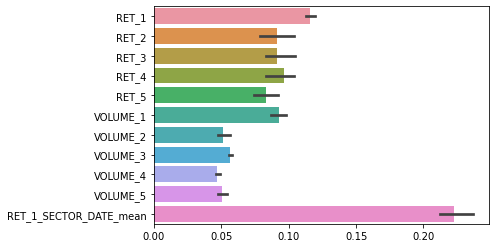

In [18]:
# Détermination de l'importance des variables explicatives sur le Benchmark QRT
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)
sns.barplot(data=feature_importances, orient='h')

Dans le modèle du Benchmark QRT, on peut voir que les variables avec le plus d'importancesont le rendement moyen du secteur de la veille puis le rendement de la veille. Les features apportant le moins au modèle sont les volumes des 2 à 5 jours précédents.

## Construction d'un modèle simple
Ce modèle nous servira de deuxième référence afin d'évaluer les modèles plus complexes.Nous réalisons un simple arbre de décision sur les features présentes du dataset d'origine.

In [19]:
# On récupère les features présent dans le dataset de base hormis la date
features_origin=x_train.columns[1:]
X_train = train[features_origin].fillna(0) #On remplace les valeurs manquantes par 0
y_train = train[target]

tree_params = {
    'max_depth': 2**4, #Profondeur maximale de 16
    'min_samples_leaf' :0.05, #Une feuille est constituée à minima de 5% de l'échantillon
    'random_state': 0
}

# Validation croisée

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scoresTrain=[]
scoresTest = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates) #On fait les séparations par rapport aux dates.

start_time = time.time() #Récupérer le temps d'éxécution

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    
    #Reconstitution des données Train et Validation (Test)
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    X_local_train = X_local_train
    X_local_test = X_local_test.fillna(0)

    tree_clf = DecisionTreeClassifier(**tree_params)
    tree_clf.fit(X_local_train, y_local_train)
    
    y_local_pred = tree_clf.predict_proba(X_local_test)[:, 1] #Proba de renvoyer True
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(tree_clf)
    
    scoretrain=tree_clf.score(X_local_train, y_local_train)
    scoresTrain.append(scoretrain)
    scoretest = accuracy_score(y_local_test, y_local_pred)
    scoresTest.append(scoretest)
    print(f"Fold {i+1} - Accuracy train: {scoretrain* 100:.2f}% - Accuracy test: {scoretest* 100:.2f}% ")

meanTree = np.mean(scoresTest)*100
stdTree = np.std(scoresTest)*100
u = (meanTree + stdTree)
l = (meanTree - stdTree)
print(f'Accuracy: {meanTree:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})',end="\n\n")
print('-----------------------------------------------------')
#print("--- %s seconds ---" % (round(time.time() - start_time,2))
cprint("--------- %s seconds ---------" % (round(time.time() - start_time,2)), 'red')
print('-----------------------------------------------------')

Fold 1 - Accuracy train: 51.88% - Accuracy test: 51.35% 
Fold 2 - Accuracy train: 52.21% - Accuracy test: 51.20% 
Fold 3 - Accuracy train: 52.14% - Accuracy test: 50.54% 
Fold 4 - Accuracy train: 52.27% - Accuracy test: 51.56% 
Accuracy: 51.16% [50.78 ; 51.54] (+- 0.58)

-----------------------------------------------------
--------- 75.86 seconds ---------
-----------------------------------------------------


In [20]:
# On estime le modèle sur l'ensemble des données
tree_clfALL = DecisionTreeClassifier(**tree_params)
tree_clfALL.fit(X_train, y_train)
print("Sur l'échantillon d'apprentissage le modèle obtient un accuracy de ",round(tree_clfALL.score(X_train, y_train),4)*100,"%")

Sur l'échantillon d'apprentissage le modèle obtient un accuracy de  52.01 %


In [21]:
#Si l'on veut soumettre notre résultat au challenge pour le précédent modèle :
X_test = test[features_origin].fillna(0)
y_pred=tree_clfALL.predict_proba(X_test)[:, 1]
sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
y_pred

array([False,  True,  True, ..., False, False,  True])

In [22]:
# Pour l'affichage des classes de l'arbre il faut une liste de string.
# Il faut en amont trier par ordre décroissant les valeurs de la variable cible par occurence

class_Names=y_train.value_counts().sort_values(ascending=False).index.values
class_Names_str=[]
for i in range(len(class_Names)):
    class_Names_str.append(str(class_Names[i]))

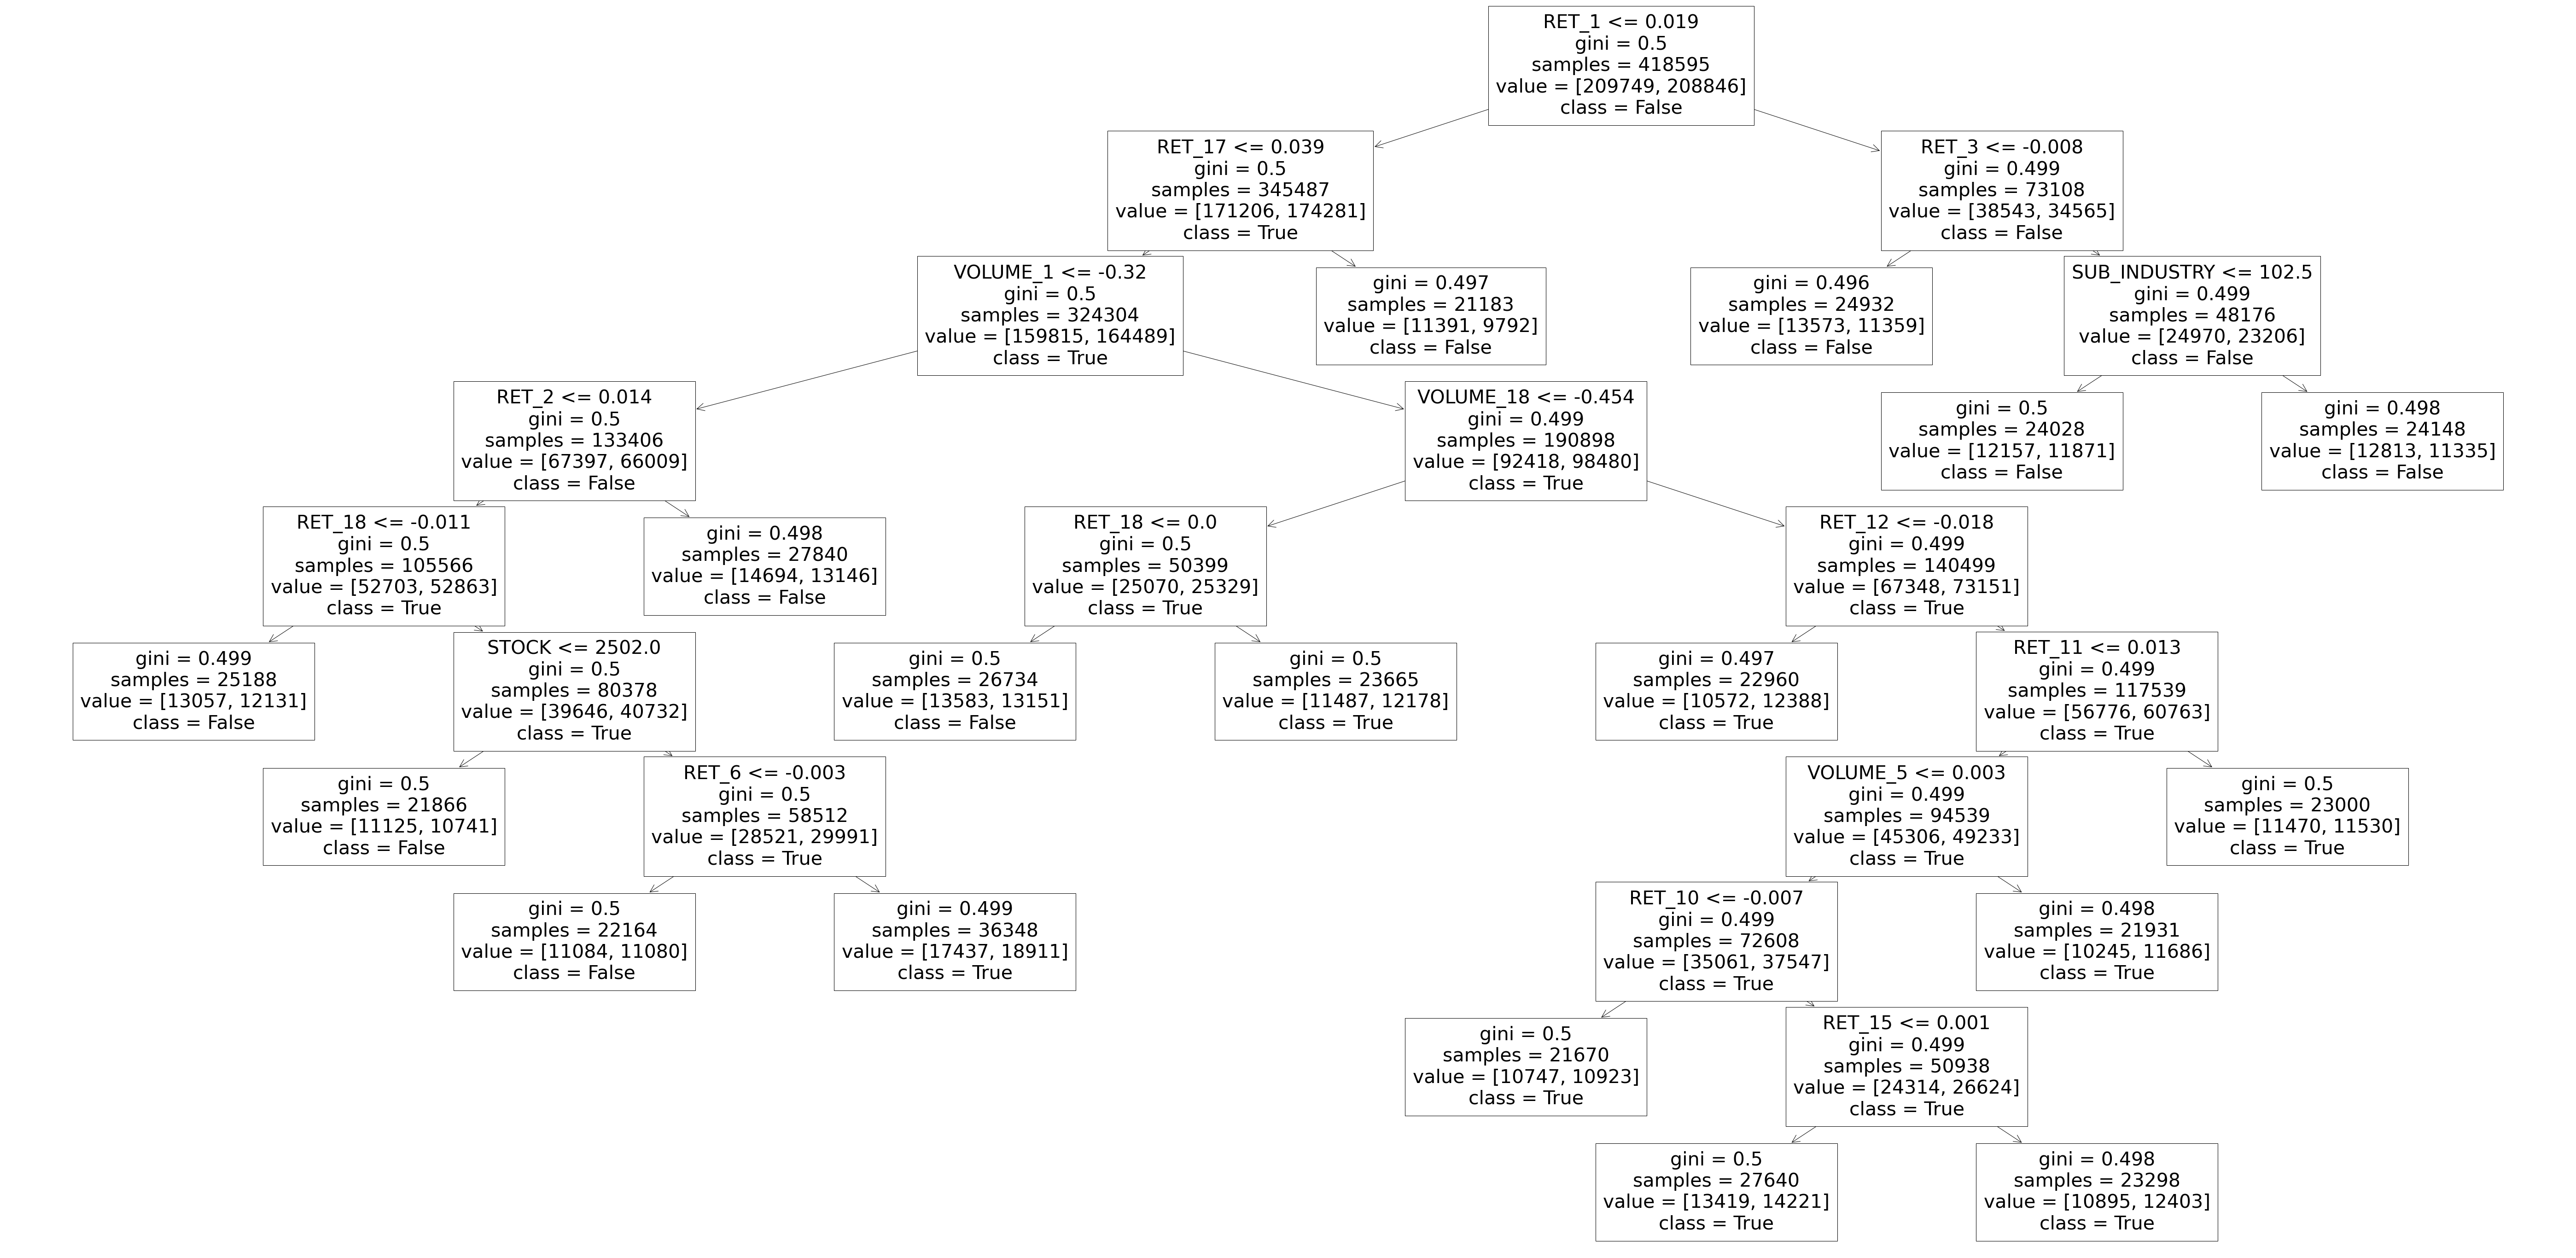

In [23]:
plt.figure(figsize=(100, 50))
plot_tree(tree_clfALL,feature_names=features_origin,class_names=class_Names_str);

<AxesSubplot:>

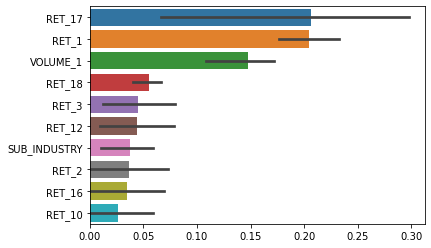

In [24]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features_origin)
#On récupère les 10 features les plus importantes

feature_importances10=feature_importances[feature_importances.mean().sort_values(ascending=False).index[:10]]
#plt.figure(figsize=(100, 50))
sns.barplot(data=feature_importances10, orient='h')

L'importance des variables explicatives de notre modèle "simpliste" ne nous apporte pas beaucoup d'information. La présence de RET_17 a la première place ne peut être justifié rationnellement. En effet aucune explication économique ou financière ne pourrait argumenter le fait que le rendement obtenu il y a 17 jours soit la variable la plus important pour prédire le rendement de demain. On peut neanmoins mettre en avant que cette variable explicative n'a pas la même importance pour chaque Fold ce qui rend par conséquent son importance moindre. Le volume et rdt de la veille garde une forte importance comme dans le Benchmark QRT. On peut voir égalament que hormis le Volume de la veille, aucun volume n'est présent dans les 10 plus importantes features. Pour finir, il est également important de constater que la sous-industry fait partie du classement. Les valeurs de cette catégorie étant numérique le modèle ne prend pas en compte cette information comme étant catégorielle. On peut notamment le voir dans l'illustration de l'arbre au dessus avec un noeud splitant les données à partir de "SUB_INDUSTRY < 102.5". Cette erreur devra être corrigée dans les prochains modèles en effectuant un retraitement en amont.

### Création de nouvelles features :
Nous allons à présent ajouter de nouvelles features permettant d'améliorer le modèle. Nous allons dans un premier temps ajouter des features conditionnelles aux sous-groupes sectoriels (Industry, Industry Group et Sub Industry) en récupérant le rendement moyen de la veille. 


In [25]:
#Fonction permettant d'évaluer l'importance des features

def Importance_Features(train,features,target,nb_importance="ALL"):
    X_train = train[features]
    y_train = train[target]

    # Paramètres de la forêt aléatoire arbitraires

    rf_params = {
        'n_estimators': 200, #Nombre d'arbre
        'max_depth': 2**3, #Profondeur maximale de l'arbre
        'random_state': 0, #Figer les résultats
        'n_jobs': -1 #Améliorer le temps d'exécution
    }

    # Validation croisée

    train_dates = train['DATE'].unique()
    test_dates = test['DATE'].unique()

    n_splits = 4
    scores = []
    models = []

    splits = KFold(n_splits=n_splits, random_state=0,
                   shuffle=True).split(train_dates)

    start_time = time.time() #Récupérer le temps d'éxécution

    for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):

        #Reconstitution 
        local_train_dates = train_dates[local_train_dates_ids]
        local_test_dates = train_dates[local_test_dates_ids]

        local_train_ids = train['DATE'].isin(local_train_dates)
        local_test_ids = train['DATE'].isin(local_test_dates)

        X_local_train = X_train.loc[local_train_ids]
        y_local_train = y_train.loc[local_train_ids]
        X_local_test = X_train.loc[local_test_ids]
        y_local_test = y_train.loc[local_test_ids]

        X_local_train = X_local_train.fillna(0)
        X_local_test = X_local_test.fillna(0)

        model = RandomForestClassifier(**rf_params)
        model.fit(X_local_train, y_local_train)

        models.append(model)
        
    feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)
    if nb_importance=="ALL":
        nb_importance=feature_importances.shape[1]
    else:
        nb_importance=max(nb_importance,feature_importances.shape[1])
    
    feature_importances_sort=feature_importances[feature_importances.mean().sort_values(ascending=False).index[:nb_importance]]
    sns.barplot(data=feature_importances_sort, orient='h')
    
    return "Temps d'éxecution : "+str(round(time.time()-start_time,2))+" sec" #En plus du graphique nous retournons le temps pris


In [26]:
Sectorial=['INDUSTRY','INDUSTRY_GROUP','SECTOR','SUB_INDUSTRY']
gb_features2=[]
for i in range(len(Sectorial)):
    gb_features2.append([Sectorial[i],'DATE'])

In [27]:
# Création de nouvelles features
new_features2 = []
shifts = [1]  # Historique utilisé
statistics = ['mean']  # the type of stat

target_feature = 'RET'
for feature_new in gb_features2:
    tmp_name = '_'.join(feature_new)
    for shift in shifts:
        for stat in statistics:
            name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
            feat = f'{target_feature}_{shift}'
            new_features2.append(name)
            for data in [train, test]:
                data[name] = data.groupby(feature_new)[feat].transform(stat)

In [28]:
target = 'RET'

n_shifts = 5  # Historique des volumes et rendements
features2 = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features2 += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features2 += new_features2  # On ajoute les features conditionnelles
train[features2].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,RET_1_INDUSTRY_DATE_mean,RET_1_INDUSTRY_GROUP_DATE_mean,RET_1_SECTOR_DATE_mean,RET_1_SUB_INDUSTRY_DATE_mean
ID,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,0.008289,0.011825,0.009178,0.008289
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,NaN,NaN,NaN,NaN,NaN,0.000671,0.002373,0.006477,0.000671
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455,0.012713,0.015527,0.013449,0.014051
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,0.030315,0.017253,0.017253,0.026870
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,0.004413,0.006210,0.006241,0.000692


<AxesSubplot:>

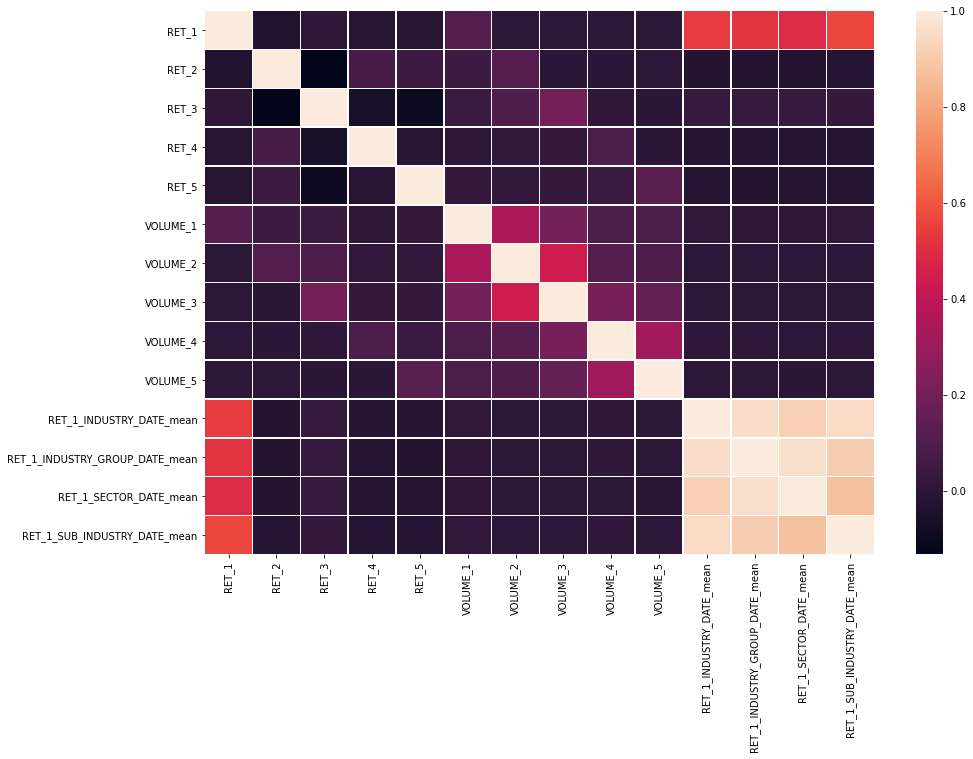

In [29]:
corr_features=train[features2].corr()
fig,ax = plt.subplots(figsize=(15,10))  
sns.heatmap(corr_features, annot=False, linewidths=.5, ax=ax)

On peut s'apercevoir que 
* les features additionnelles aux différents échellons de secteurs ont une forte corrélation. Ce résultat n'est en effet pas suprenant. Nous n'utiliserons pas l'ensemble de ces features en même temps. Afin de sélectionner la features ayant le plus d'importance nous avons réalisé une forêt aléatoire identique au Benchmark QRT mais en y ajoutant nos nouvelles features (résultats ci dessous). Nous constatons que la feature des secteurs a le plus d'importance. Nous décidons de conserver celle-ci. Néanmoins la feature de l'Industry_Groupe (Deuxième échellon de classification après secteur) pourra être utilisée si nous décidons de créer un modèle par secteur.

* Une corrélation existe entre le rendement en J-1 et le rendement moyen en J-1 des catégories sectorielles. Cette corrélation semble toutefois logique au vue de la construction des nouvelles features.

* Il existe une faible corrélation entre les volumes de jours proches (Volumes J-1 et J-2 par exemple) ainsi qu'une légère corrélation entre le Volume et le Rendement du même jour. Ces deux observations vont dans le sens de l'observation précédemment faite sur l'importance des features où le Volume de la veille présentait une feature importante dans le Benchmark QRT.

"Temps d'éxecution : 215.92 sec"

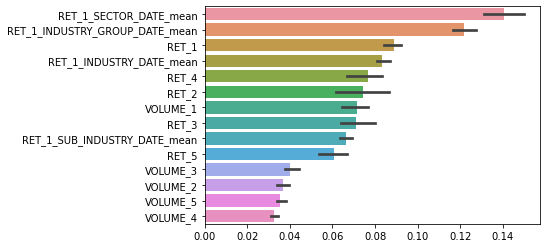

In [30]:
#Déterminer les 10 features les plus importantes :

Importance_Features(train,features2,target,10)

In [31]:
# Création de la nouvelle feature : Récupère la moyenne et l'écart-type du volume et des rendements
# de la veille par secteur

new_features3 = []
# Conditional aggregated features
shifts = [1]  # Choose some different shifts
statistics = ['mean','std']  # the type of stat
gb_features = ['SECTOR', 'DATE']
target_features = ['VOLUME','RET']
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        for target_feature in target_features :
            name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
            feat = f'{target_feature}_{shift}'
            new_features3.append(name)
            for data in [train, test]:
                data[name] = data.groupby(gb_features)[feat].transform(stat)

# Ajout la moyenne de rendement et des volumes LT (de 6 à 20 jours)
n_shift_start=6
n_shifts_end = 20  # If you don't want all the shifts to reduce noise
for target_feature in target_features :
    features = [str(target_feature)+'_%d' % (i + 1) for i in range(n_shift_start,n_shifts_end)]
    name = f'{target_feature}_{"mean"}_{n_shift_start}_{n_shifts_end}'  
    new_features3.append(name)
    for data in [train, test]:
        data[name] = data[features].mean(axis=1)

In [32]:
target = 'RET'

n_shifts = 5  # Historique des volumes et rendements
features3 = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features3 += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features3 += new_features3   # On ajoute les features conditionnelles
x_train3=train[features3]
y_train=train[target]

"Temps d'éxecution : 275.05 sec"

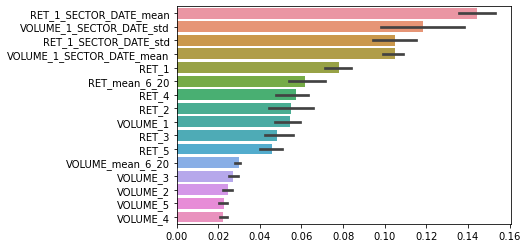

In [33]:
#Déterminer les 10 features les plus importantes :
Importance_Features(train,features3,target,10)

Nous pouvons constater que la plupart des features rajoutées font parties des variables explicatives les plus importantes.

<AxesSubplot:>

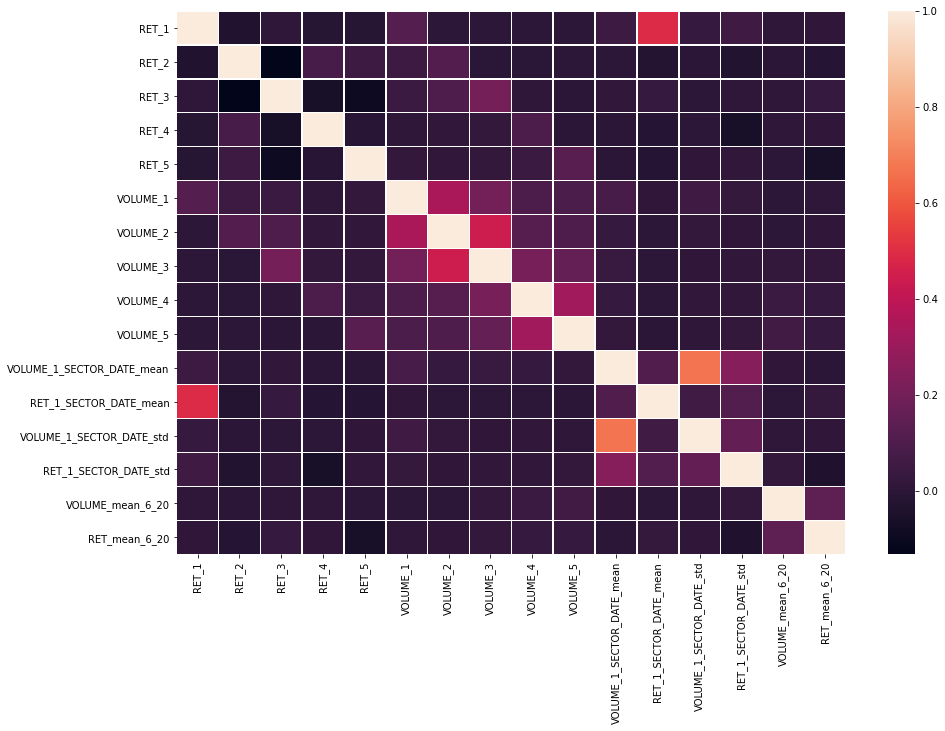

In [34]:
#Corrélation entre features :

fig,ax = plt.subplots(figsize=(15,10))  
sns.heatmap(x_train3.corr(), annot=False, linewidths=.5, ax=ax)

Une corrélation de plus de 67% existe entre le moyenne et l'écart type du volume sectoriel en J-1. Malgré une plus grande importance de l'écart type du volume du secteur, nous décidons de la retirer dans la mesure où le volume est relatif au marché ainsi qu'aux volumes passé de l'actif.

In [35]:
#Suppression de la Feature
features3.remove('VOLUME_1_SECTOR_DATE_std')

In [36]:
featuresN=features3
print('Nous disposons alors des features quantitatives suivantes :',end='\n\n')
print(featuresN,end='\n\n')

print("Nous avons également les features catégoriels suivantes :",end='\n\n')
print(Descr)


Nous disposons alors des features quantitatives suivantes :

['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5', 'VOLUME_1', 'VOLUME_2', 'VOLUME_3', 'VOLUME_4', 'VOLUME_5', 'VOLUME_1_SECTOR_DATE_mean', 'RET_1_SECTOR_DATE_mean', 'RET_1_SECTOR_DATE_std', 'VOLUME_mean_6_20', 'RET_mean_6_20']

Nous avons également les features catégoriels suivantes :

['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY']


In [37]:
#Identification des dates où il n'y a aucun rendement

LesDates=train['DATE'].unique()
nbdate=len(train['DATE'].unique())
values_names=[]
values_names = ['RET_%d' % (i + 1) for i in range(20)]
dateNA=[]
for i in range(nbdate):
    nbligne=train[train['DATE']==LesDates[i]].shape[0]
    nbNA_rows=train[train['DATE']==LesDates[i]][values_names].isna().sum().sum()/len(values_names)
    if nbligne==nbNA_rows:
        dateNA.append(LesDates[i])
print("Les Dates n'ayant aucun rendement pour aucun actif :",end='\n\n')
print(dateNA)

#Suppression des dates avec aucun rendement
for i in range(len(dateNA)):
    train=train[train['DATE']!=dateNA[i]]


Les Dates n'ayant aucun rendement pour aucun actif :

[42]


### Réduction de l'échantillon d'apprentissage

On réduit la taille de notre échantillon d'apprentissage pour gagner en temps d'éxécution.
Afin de simplifier les choses, nous ne rééquilibrerons pas la variable cible.
ie : on détermine si la variable cible est Vrai avec .predict et non en regardant si predict_proba est supérieur à la médiane 
des probas prédites à la même date. En effet la fonction GridSearchCV ne nous permet pas, à notre connaissance, de modifier la prédiction en se rapportant à la médiane de chaque date. L'objectif étant ici d'étudier la performance de différents modèles afin d'arbitrer entre ces derniers et d'en récupérer les praramètres optimaux. La cross-validation utilisée dans le GridSearchCV nous permet de limiter la présence de sur-apprentissage.

Quand le choix du modèle sera fait, nous pourrons recontrôler sur une base de train-validation-test l'absence de sur-apprentissage et également évaluer la performance en déterminant la prédiction de la variable cible qui se rapproche plus de la problématique. 

In [38]:
LesDates=train['DATE'].unique()
nbdate=len(LesDates)

In [39]:
#Réduction du nombre de données : affichage du respect de la proportion de la valeure cible.

print(train[target].value_counts(True))
train_reduce=train.sample(n=50000, random_state=42)
print(train_reduce[target].value_counts(True),end="\n\n")

# Séparation des données en train/test
trainR, testR = train_test_split(train_reduce, test_size=0.2, random_state = 42)

False    0.501083
True     0.498917
Name: RET, dtype: float64
True     0.5013
False    0.4987
Name: RET, dtype: float64



In [40]:
features3

['RET_1',
 'RET_2',
 'RET_3',
 'RET_4',
 'RET_5',
 'VOLUME_1',
 'VOLUME_2',
 'VOLUME_3',
 'VOLUME_4',
 'VOLUME_5',
 'VOLUME_1_SECTOR_DATE_mean',
 'RET_1_SECTOR_DATE_mean',
 'RET_1_SECTOR_DATE_std',
 'VOLUME_mean_6_20',
 'RET_mean_6_20']

In [41]:
#On sépare les features de la variable cible.
X_train=trainR[features3]
y_train=trainR[target]
X_test=testR[features3]
y_test=testR[target]

Nous allons analysé les résultats obtenus avec une régression logistique, un RandomForestClassifier ainsi que le KNeighborsClassifier. A l'aide de la fonction GridSearchCV, nous allons déterminons les paramètres qui maximisent l'accuracy moyenne (cross-validation=3). 

### Attention code LONG

In [42]:
models = [("logreg", LogisticRegression(max_iter=500)),("rdm_frt", RandomForestClassifier(n_jobs= -1)),
         ("knn", KNeighborsClassifier(n_jobs= -1))]

#Ajout des paramètres que nous souhaitons faire varier

grids = {"logreg" : {'logreg__C': np.logspace(-2, 2, 5, base=2),
                    'logreg__solver' :['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
        "rdm_frt" : {  'rdm_frt__max_depth': [4, 6, 8],
                         'rdm_frt__max_features': ['sqrt','log2'],
                         'rdm_frt__criterion' : ['gini', 'entropy'],
                         'rdm_frt__min_samples_split': [0.01, 0.05, 0.1],
                         'rdm_frt__oob_score':[True,False],
                         'rdm_frt__n_estimators': [100, 200,300]},
          "knn" : {'knn__n_neighbors': [1,3,5],
                  'knn__algorithm' : ['ball_tree', 'kd_tree', 'brute'], #'auto' est supprimé car cherche lui même le meilleur algo --> Gain de temps par la suite
                  'knn__weights' :['uniform', 'distance']} 
        }

numeric_transformer = Pipeline(steps=[
                                    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
                                    ('scaler', StandardScaler())])

preproc = ColumnTransformer(transformers=[("num", numeric_transformer, features3)])

crossval=3
modelsOpt=[]

for name, model in models:
    start_time = time.time()
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=crossval,n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test) #On récupère la prédiction sur la base de test
    score_test=accuracy_score(y_pred, y_test)
    modelsOpt.append(clf) #On stock le modèle optimal
    print('Résultat pour : {}'.format(name))
    print('Hyper-paramètres: {}'.format(clf.best_params_))
    print('Meilleur accuracy sur train (crossval) est: {}'.format(clf.best_score_))
    print('Accuracy sur test est: {}'.format(score_test))
    cprint("--------- %s secondes ---------" % (round(time.time() - start_time,2)), 'red')
    print('-----------------------------------------------------')

Résultat pour : logreg
Hyper-paramètres: {'logreg__C': 1.0, 'logreg__solver': 'sag'}
Meilleur accuracy sur train (crossval) est: 0.5104750350122185
Accuracy sur test est: 0.5114
--------- 44.44 secondes ---------
-----------------------------------------------------
Résultat pour : rdm_frt
Hyper-paramètres: {'rdm_frt__criterion': 'gini', 'rdm_frt__max_depth': 8, 'rdm_frt__max_features': 'log2', 'rdm_frt__min_samples_split': 0.01, 'rdm_frt__n_estimators': 100, 'rdm_frt__oob_score': False}
Meilleur accuracy sur train (crossval) est: 0.5290252400302808
Accuracy sur test est: 0.5251
--------- 2306.6 secondes ---------
-----------------------------------------------------
Résultat pour : knn
Hyper-paramètres: {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Meilleur accuracy sur train (crossval) est: 0.5276749944097335
Accuracy sur test est: 0.5274
--------- 489.85 secondes ---------
-----------------------------------------------------


#### Commentaires résultats : 

Au vu des résultats observés sur l'accuracy moyenne des échantillon de validation nous ne retiendront pas le modèle LogisticRegression car il obtient de moins bons résultats que nos benchmark. Son utilisation même dans un VotingClassifier viendrait certainement amoindrir les performances des autres modèles.
Les résultats sur les fôrets aléatoires ainsi que KNeighborsClassifier sont intéressants avec des accuracy meilleurs que nos benchmark. Il est toutefois important de noter que la comparaison avec nos Benchmark est limité par la réduction de l'échatillon d'apprentissage ainsi que la différence de prédiction. 

In [43]:
#Sinon On stock les paramètres optimaux des modèles dans Best Param
BestParam={}
for i in range(len(models)): 
    BestParam[models[i][0]]=modelsOpt[i].best_params_
    

In [44]:
#On récupère les paramètres optimaux des méthodes sélectionnés.
rdm_frt_opt=RandomForestClassifier(n_jobs= -1,
                                   criterion=BestParam['rdm_frt']['rdm_frt__criterion'],
                                   max_depth=BestParam['rdm_frt']['rdm_frt__max_depth'],
                                   max_features=BestParam['rdm_frt']['rdm_frt__max_features'],
                                   min_samples_split=BestParam['rdm_frt']['rdm_frt__min_samples_split'],
                                   n_estimators=BestParam['rdm_frt']['rdm_frt__n_estimators'])

knn_opt=KNeighborsClassifier(n_jobs= -1,
                             algorithm=BestParam['knn']['knn__algorithm'],
                             n_neighbors=BestParam['knn']['knn__n_neighbors'],
                             weights=BestParam['knn']['knn__weights'])



Ci-dessous la mise en place du VotingClassifier. Dans la mesure où nous avons sélectionnés 2 méthodes, nous avons décidé d'appliquer un vote soft afin d'éviter des égalités où le VotingClassifier prendrait arbitrairement le résultat du premier learner.

Vous trouverez une version épurée de notre modèle, l'évaluation du VotingClassifier sur l'ensemble des données se trouve après mais est très long. De plus nous nous sommes rendus-compte que les résultats du VotingClassifier ètait largement en dessous des deux méthodes sélectionnées ce qui nous a fournit une indice sur **la présence d'over-fitting**. 
Les codes ci-dessous permettront de le mettre en évidence plus rapidement qu'avec le code général qui se retrouve être inutile ...L'overfitting est intégralement causé par le Knn, la propabilité prédit par celui-ci écrase totalement les résultats trouvés par la forêt aléatoire (voting "soft"). Malgré la présence d'overfitting dans le KNN, nous pouvons constaté que les résultats obtenus avec la forêt aléatoire sont convenables.

In [92]:
# Selection d'un deuxième jeu de données.

train_reduce2=train.sample(n=100000, random_state=37)
trainR2, testR2 = train_test_split(train_reduce2, test_size=0.2, random_state = 37)

X_train2=trainR2[features3]
y_train2=trainR2[target]
X_test2=testR2[features3]
y_test2=testR2[target]

In [93]:
# Mise en place du VotingClassifier 'soft' et affichage résultats


numeric_transformer = Pipeline(steps=[
                                    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
                                    ('scaler', StandardScaler())])

preproc = ColumnTransformer(transformers=[("num", numeric_transformer, features3)])


voting_clf = VotingClassifier(
    estimators=[('rdm_frt_opt', rdm_frt_opt), ('knn_opt', knn_opt)],
    voting='soft',
    n_jobs=-1)

pipe_clfTest = Pipeline(steps=[('preprocessor', preproc), ('voting_clf', voting_clf)])

pipe_clfTest.fit(X_train2, y_train2)
print('---------VotingClassifier---------')
print('Score sur la base de train :',pipe_clfTest.score(X_train2, y_train2))
Y_vot_pred=pipe_clfTest.predict(X_test2)
score_vot=accuracy_score(Y_vot_pred, y_test2)
print('Score sur la base de test :',score_vot,end='\n\n')


# RandomForestClassifier : Résultats Train/Test

pipe_rdm_frt_opt = Pipeline(steps=[('preprocessor', preproc), ('rdm_frt_opt', rdm_frt_opt)])
pipe_rdm_frt_opt.fit(X_train2, y_train2)
print('---------RandomForestClassifier---------')
print('Score sur la base de train :',pipe_rdm_frt_opt.score(X_train2, y_train2))
Y_vot_pred=pipe_rdm_frt_opt.predict(X_test2)
score_vot=accuracy_score(Y_vot_pred, y_test2)
print('Score sur la base de test :',score_vot,end='\n\n')


# KNeighborsClassifier : Résultats Train/Test

pipe_knn_opt = Pipeline(steps=[('preprocessor', preproc), ('knn_opt', knn_opt)])
pipe_knn_opt.fit(X_train2, y_train2)
print('---------KNeighborsClassifier---------')
print('Score sur la base de train :',pipe_knn_opt.score(X_train2, y_train2))
Y_vot_pred=pipe_knn_opt.predict(X_test2)
score_vot=accuracy_score(Y_vot_pred, y_test2)
print('Score sur la base de test :',score_vot)

---------VotingClassifier---------
Score sur la base de train : 1.0
Score sur la base de test : 0.53015

---------RandomForestClassifier---------
Score sur la base de train : 0.56415
Score sur la base de test : 0.53435

---------KNeighborsClassifier---------
Score sur la base de train : 1.0
Score sur la base de test : 0.53025


KNClassifier :Matrice de confusion pour train et test :


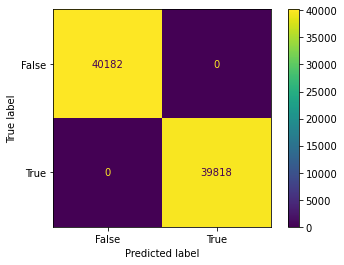

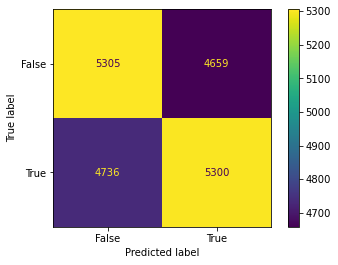

In [94]:
print('KNClassifier :Matrice de confusion pour train et test :')
plot_confusion_matrix(pipe_knn_opt, X_train2, y_train2, values_format = '')
plot_confusion_matrix(pipe_knn_opt, X_test2, y_test2, values_format = '')


En la présence d'overfitting dans le modèle KN et par construction le modèle VotingClassifier, nous ne retiendrons pas ce modèle. Néanmoins la fôret aléatoire utilisant les paramètres optimaux fonctionne bien et améliore les résultats de nos différents benchmark. Ce qui est une satisfaction de cette partie.

## Modèles par secteur :

Au vu des résultats du Benchmark QRT, nous avons pu constater que les secteurs avaient une grande importance dans le modèle. Nous proposons alors de réaliser un modèle par secteur. De ce fait, nous allons pouvoir utiliser des features conditionnelles aux groupement sectoriel INDUSTRY_GROUP (échellon 2). Ces features étaient fortement corrélées avec celles du "SECTOR" mais ètaient importantes dans notre forêt aléatoire de sélection de features.
Les modèles étant par secteur, nous décidons de supprimer les features conditionnelles aux secteurs.

In [49]:
#Pour les secteurs
features_sector=features3.copy()
todel=['RET_1_SECTOR_DATE_mean','RET_1_SECTOR_DATE_std','VOLUME_1_SECTOR_DATE_mean']
for element_del in todel:
    features_sector.remove(element_del)

# On construit les features conditionnelles en prenant 'INDUSTRY_GROUP' au lieu de 'SECTOR'

new_featuresS = []
shifts = [1]  # Choose some different shifts
statistics = ['mean','std']  # the type of stat
gb_features = ['INDUSTRY_GROUP', 'DATE']
target_features = ['VOLUME','RET']
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        for target_feature in target_features :
            name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
            feat = f'{target_feature}_{shift}'
            new_featuresS.append(name)
            for data in [train, test]:
                data[name] = data.groupby(gb_features)[feat].transform(stat)
                
features_sector+=new_featuresS

print("Les features utilisés pour le modèle par secteur sont :",end='\n\n')
features_sector

Les features utilisés pour le modèle par secteur sont :



['RET_1',
 'RET_2',
 'RET_3',
 'RET_4',
 'RET_5',
 'VOLUME_1',
 'VOLUME_2',
 'VOLUME_3',
 'VOLUME_4',
 'VOLUME_5',
 'VOLUME_mean_6_20',
 'RET_mean_6_20',
 'VOLUME_1_INDUSTRY_GROUP_DATE_mean',
 'RET_1_INDUSTRY_GROUP_DATE_mean',
 'VOLUME_1_INDUSTRY_GROUP_DATE_std',
 'RET_1_INDUSTRY_GROUP_DATE_std']

In [50]:
#Pour stocker les données propres à chaques secteurs
LesSecteur=train['SECTOR'].unique()
sectors_sample={}
sectors_sample={}
for sect in LesSecteur:
    df_sect=train[train['SECTOR']==sect]
    sectors_sample[sect]=df_sect

In [51]:
#Nous utilisons les paramètres issus de l'optimisation GridSearch de la première partie.
print(rdm_frt_opt)
preproc_sector = ColumnTransformer(transformers=[("num", numeric_transformer, features_sector)])
pipe_rdm_frt_sect = Pipeline(steps=[('preprocessor', preproc_sector), ('rdm_frt_opt', rdm_frt_opt)])

RandomForestClassifier(max_depth=8, max_features='log2', min_samples_split=0.01,
                       n_jobs=-1)


In [52]:
# Paramètres de la forêt aléatoire utilisé
n_splits = 4
scores = []
scoresTrains=[]
models = []
scoreSect={}

start_time = time.time() #Récupérer le temps d'éxécution

for nameS,train_sector in sectors_sample.items(): # On parcourt le dictionnaire des Secteur
    X_train = train_sector[features_sector]
    y_train = train_sector[target]
    
    train_dates = train_sector['DATE'].unique()
    test_dates = test['DATE'].unique()
    
    splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)
    
    #On réinitialise les scores
    scores = [] 
    scoresTrains=[]
    print( 'Secteur :',nameS)
    for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
        #Reconstitution 
        local_train_dates = train_dates[local_train_dates_ids]
        local_test_dates = train_dates[local_test_dates_ids]

        local_train_ids = train_sector['DATE'].isin(local_train_dates)
        local_test_ids = train_sector['DATE'].isin(local_test_dates)

        X_local_train = X_train.loc[local_train_ids]
        y_local_train = y_train.loc[local_train_ids]
        X_local_test = X_train.loc[local_test_ids]
        y_local_test = y_train.loc[local_test_ids]
        
        model=pipe_rdm_frt_sect
        model.fit(X_local_train, y_local_train)

        # On récupère la proba d'avoir True sur l'échantillon d'apprentissage
        if pd.DataFrame(y_local_train)['RET'].value_counts().index[0] == True :
            y_local_pred_train = model.predict_proba(X_local_train)[:, 0]
        else:
            y_local_pred_train = model.predict_proba(X_local_train)[:, 1]
            
        sub = train_sector.loc[local_train_ids].copy()
        sub['pred'] = y_local_pred_train
        y_local_pred_train = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values
        
        # On récupère la proba d'avoir True sur l'échantillon de test
        if pd.DataFrame(y_local_test)['RET'].value_counts().index[0] == True :
            y_local_pred = model.predict_proba(X_local_test)[:, 0]
        else :
            y_local_pred = model.predict_proba(X_local_test)[:, 1]

        sub = train_sector.loc[local_test_ids].copy()
        sub['pred'] = y_local_pred
        y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

        models.append(model)
        score = accuracy_score(y_local_test, y_local_pred)
        scores.append(score)
        scoreTrain = accuracy_score(y_local_pred_train, y_local_train)
        scoresTrains.append(scoreTrain)
        print(f"Fold {i+1} - Accuracy validation: {score* 100:.2f}%")

    mean = np.mean(scores)*100
    std = np.std(scores)*100
    meanTrain=np.mean(scoresTrains)*100
    stdTrain=np.std(scoresTrains)*100
    scoreSect[nameS]=[mean,std,meanTrain,stdTrain] #On stock pour chaque secteur la moyenne et écrat type des accuracy sur la base train et test
    u = (mean + std)
    l = (mean - std)
    print(f'Accuracy - secteur {nameS}: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')
    print('-----------------------------------------------------')
    print('-----------------------------------------------------',end='\n\n')

# On récupère le score moyen de chaque secteur
score_all_sectors=[]
for nameS,train_sector in sectors_sample.items():
    score_all_sectors.append(scoreSect[nameS][0])
    
meanAll = np.mean(score_all_sectors)
stdAll = np.std(score_all_sectors)
u = (meanAll + stdAll)
l = (meanAll - stdAll)
print(f'Accuracy Moyenne de tous les secteurs : {meanAll:.2f}% [{l:.2f} ; {u:.2f}] (+- {stdAll:.2f})')
cprint("--------- %s seconds ---------" % (round(time.time() - start_time,2)), 'red')


Secteur : 3
Fold 1 - Accuracy validation: 48.13%
Fold 2 - Accuracy validation: 49.04%
Fold 3 - Accuracy validation: 51.95%
Fold 4 - Accuracy validation: 50.70%
Accuracy - secteur 3: 49.96% [48.48 ; 51.43] (+- 1.47)
-----------------------------------------------------
-----------------------------------------------------

Secteur : 6
Fold 1 - Accuracy validation: 51.62%
Fold 2 - Accuracy validation: 48.21%
Fold 3 - Accuracy validation: 49.68%
Fold 4 - Accuracy validation: 48.94%
Accuracy - secteur 6: 49.61% [48.34 ; 50.89] (+- 1.27)
-----------------------------------------------------
-----------------------------------------------------

Secteur : 8
Fold 1 - Accuracy validation: 50.60%
Fold 2 - Accuracy validation: 50.39%
Fold 3 - Accuracy validation: 51.35%
Fold 4 - Accuracy validation: 50.14%
Accuracy - secteur 8: 50.62% [50.17 ; 51.07] (+- 0.45)
-----------------------------------------------------
-----------------------------------------------------

Secteur : 1
Fold 1 - Accurac

Les résultats en faisant notre modèle par secteur peut paraître faible. En effet les faibles résultats sont causés par le recalcul de nos y_pred en utilisant les probabilités prédites. En temps normal nous comparant nos probabilités à la médiane du marché de la même journée afin de déterminer si oui ou non une valeur va surperformer le marché demain. Dans le code ci-dessus, **nous déterminons si une action va surperformer son secteur et non le marché**. La prédiction est donc faussée. Nous allons ci-dessous construire une évaluation plus pertinente de notre modèle. Pour ce faire, le Kfold ne sera pas fait par secteur mais en amont. Pour chaque split de dates, nous allons appliqué la fôret aléatoire sur chaque secteur puis nous réunirons les résultats de tous les secteurs afin de pouvoir prédire si une action surperforme le marché à une date donnée.

In [54]:
n_splits = 4
scores = []
scoresTrains=[]
models = []
scoreSect={}
resul_direct=[]

start_time = time.time() #Récupérer le temps d'éxécution

splits = KFold(n_splits=n_splits, random_state=12,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    #Nous permet de stocker les predict proba récupérer par chaque secteur
    df_proba_train=pd.DataFrame() 
    df_proba_test=pd.DataFrame()
    for nameS,train_sector in sectors_sample.items(): 
        
        #Reconstitution : Séparation sur train car certains secteurs n'ont pas toutes les dates
        train_dates = train['DATE'].unique()
        local_train_dates = train_dates[local_train_dates_ids]
        local_test_dates = train_dates[local_test_dates_ids]
        
        local_train_ids = train['DATE'].isin(local_train_dates)
        local_test_ids = train['DATE'].isin(local_test_dates)
        
        local_train=train.loc[local_train_ids]
        local_test=train.loc[local_test_ids]
        
        #On récupère le secteur concerné
        local_train=local_train[local_train['SECTOR']==nameS]
        local_test=local_test[local_test['SECTOR']==nameS]
        
        X_local_train = local_train[features_sector]
        y_local_train = local_train[target]
        X_local_test = local_test[features_sector]
        y_local_test = local_test[target]
        
        pp_test=local_test.loc[:,['DATE', 'RET','SECTOR']]
        pp_train=local_train.loc[:,['DATE', 'RET','SECTOR']]
        
        model=pipe_rdm_frt_sect
        model.fit(X_local_train, y_local_train)

        # On récupère la proba d'avoir True sur l'échantillon d'apprentissage
        if pd.DataFrame(y_local_train)['RET'].value_counts().index[0] == True :
            y_local_pred_train = model.predict_proba(X_local_train)[:, 0]
        else:
            y_local_pred_train = model.predict_proba(X_local_train)[:, 1]
            
        #On stock également les prédictions directs
        y_local_preddirect_train=model.predict(X_local_train)

        sub = train_sector.loc[local_train_ids].copy()
        sub['pred'] = y_local_pred_train
        sub['preddirect'] = y_local_preddirect_train
        pp_train=pp_train.merge(sub.loc[:,['pred','preddirect']],left_index=True,right_index=True,how='outer')
        
        # On récupère la proba d'avoir True sur l'échantillon de test
        if pd.DataFrame(y_local_test)['RET'].value_counts().index[0] == True :
            y_local_pred = model.predict_proba(X_local_test)[:, 0]
        else :
            y_local_pred = model.predict_proba(X_local_test)[:, 1]
        #On stock également les prédictions directs
        y_local_preddirect_test=model.predict(X_local_test)
        
        sub = train_sector.loc[local_test_ids].copy()
        sub['pred'] = y_local_pred
        sub['preddirect'] = y_local_preddirect_test
        pp_test=pp_test.merge(sub.loc[:,['pred','preddirect']],left_index=True,right_index=True,how='outer')
        
        #On stock les probas du secteur. De part la construction on est assuré que les indices sont uniques
        df_proba_train=pd.concat([df_proba_train,pp_train])
        df_proba_test=pd.concat([df_proba_test,pp_test])
        
    #On a récupérer le predict proba de chaque secteur
    #on peut maintenant déterminer les True/False en fonction du marché
    y_local_pred = df_proba_test.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values
    y_local_pred_train=df_proba_train.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values
    
    #On récupère les probas directs
    y_local_pred_direct=df_proba_test['preddirect'].values
    y_local_pred_train_direct=df_proba_train['preddirect'].values
    
    #On récupère également les vraies valeurs de y
    y_fold_train=df_proba_train[target].values
    y_fold_test=df_proba_test[target].values

    #Calcul des accuracy sur les prédictions aggregées par dates
    score = accuracy_score(y_local_pred, y_fold_test)
    scores.append(score)
    scoreTrain = accuracy_score(y_local_pred_train,y_fold_train)
    scoresTrains.append(scoreTrain)
    print(f"Fold {i+1} - Accuracy train: {scoreTrain* 100:.2f}% - Accuracy validation: {score* 100:.2f}%")
    
    
    #Stockage Accuracy de la prédiction direct - sur train puis test
    resul_direct.append([accuracy_score(y_local_pred_train_direct, y_local_pred_train),\
                         accuracy_score(y_local_pred_direct, y_fold_test),])

mean = np.mean(scores)*100
std = np.std(scores)*100
meanTrain=np.mean(scoresTrains)*100
stdTrain=np.std(scoresTrains)*100
scoreSect[nameS]=[mean,std,meanTrain,stdTrain] #On stock pour chaque secteur la moyenne et écrat type des accuracy sur la base train et test
u = (mean + std)
l = (mean - std)
utrain = (meanTrain + stdTrain)
ltrain = (meanTrain - stdTrain)
print("")
print('-----------------------------------------------------')
print(f'Accuracy - Test: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')
print(f'Accuracy - Train: {meanTrain:.2f}% [{ltrain:.2f} ; {utrain:.2f}] (+- {stdTrain:.2f})')
print('-----------------------------------------------------',end='\n\n')

cprint("--------- %s seconds ---------" % (round(time.time() - start_time,2)),'red')

Fold 1 - Accuracy train: 53.99% - Accuracy validation: 49.08%
Fold 2 - Accuracy train: 53.46% - Accuracy validation: 49.90%
Fold 3 - Accuracy train: 51.92% - Accuracy validation: 49.60%
Fold 4 - Accuracy train: 57.09% - Accuracy validation: 50.44%

-----------------------------------------------------
Accuracy - Test: 49.75% [49.26 ; 50.25] (+- 0.49)
Accuracy - Train: 54.12% [52.24 ; 56.00] (+- 1.88)
-----------------------------------------------------

--------- 79.73 seconds ---------


In [55]:
#Affichage des résultatspour une prédiction direct (sans la surper de la proba prédite)
print("En utilisant .predict directement :",end='\n\n')

for i in range(len(resul_direct)):
    print(f"Fold {i+1} - Accuracy train: {resul_direct[i][0]* 100:.2f}% - Accuracy validation: {resul_direct[i][1]* 100:.2f}%")

print("")
print('On constate un overfitting du modèle')

En utilisant .predict directement :

Fold 1 - Accuracy train: 65.84% - Accuracy validation: 51.66%
Fold 2 - Accuracy train: 64.07% - Accuracy validation: 51.42%
Fold 3 - Accuracy train: 58.61% - Accuracy validation: 51.07%
Fold 4 - Accuracy train: 80.49% - Accuracy validation: 50.60%

On constate un overfitting du modèle


Les paramètres optimisés de la rdm_for sur l'ensemble des données ne conviennent plus dans notre cas de figure. Les arbres sont très versatiles quand au changement de données. Au vu du temps pris pour l'optimisation, nous n'allons pas optimisé les paramètres pour chaque échantillon sectoriel. Cette optimisation ne sera pas faite car nous avons aussi pu constaté que le GridSearchCV ne nous assurait pas une absence d'overfitting. De ce fait, nous avons décider de restreindre les paramètres de notre fôret aléatoire afin d'éviter ce phénomène. Nous allons :
* augmenter le nombre d'arbres estimés à 500; 
* réduire la profondeur maximale;
* augmenter la proportion minimale d'observations à chaque feuille;

In [56]:
rdm_frt_sect=RandomForestClassifier(n_jobs= -1,
                                   criterion='gini',
                                   max_depth=6,
                                   max_features='log2',
                                   min_samples_split=0.05,
                                   n_estimators=500)

pipe_rdm_frt_sect2 = Pipeline(steps=[('preprocessor', preproc_sector), ('rdm_frt_sect', rdm_frt_sect)])

In [57]:
n_splits = 4
scores = []
scoresTrains=[]
models = []
scoreSect={}
resul_direct=[]

start_time = time.time() #Récupérer le temps d'éxécution

splits = KFold(n_splits=n_splits, random_state=22,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    #Nous permet de stocker les predict proba récupérer par chaque secteur
    df_proba_train=pd.DataFrame() 
    df_proba_test=pd.DataFrame()
    for nameS,train_sector in sectors_sample.items(): 
        
        #Reconstitution : Séparation sur train car certains secteurs n'ont pas toutes les dates
        train_dates = train['DATE'].unique()
        local_train_dates = train_dates[local_train_dates_ids]
        local_test_dates = train_dates[local_test_dates_ids]
        
        local_train_ids = train['DATE'].isin(local_train_dates)
        local_test_ids = train['DATE'].isin(local_test_dates)
        
        local_train=train.loc[local_train_ids]
        local_test=train.loc[local_test_ids]
        
        #On récupère le secteur concerné
        local_train=local_train[local_train['SECTOR']==nameS]
        local_test=local_test[local_test['SECTOR']==nameS]
        
        X_local_train = local_train[features_sector]
        y_local_train = local_train[target]
        X_local_test = local_test[features_sector]
        y_local_test = local_test[target]
        
        pp_test=local_test.loc[:,['DATE', 'RET','SECTOR']]
        pp_train=local_train.loc[:,['DATE', 'RET','SECTOR']]
        
        model=pipe_rdm_frt_sect2
        model.fit(X_local_train, y_local_train)

        # On récupère la proba d'avoir True sur l'échantillon d'apprentissage
        if pd.DataFrame(y_local_train)['RET'].value_counts().index[0] == True :
            y_local_pred_train = model.predict_proba(X_local_train)[:, 0]
        else:
            y_local_pred_train = model.predict_proba(X_local_train)[:, 1]
            
        #On stock également les prédictions directs
        y_local_preddirect_train=model.predict(X_local_train)

        sub = train_sector.loc[local_train_ids].copy()
        sub['pred'] = y_local_pred_train
        sub['preddirect'] = y_local_preddirect_train
        pp_train=pp_train.merge(sub.loc[:,['pred','preddirect']],left_index=True,right_index=True,how='outer')
        
        # On récupère la proba d'avoir True sur l'échantillon de test
        if pd.DataFrame(y_local_test)['RET'].value_counts().index[0] == True :
            y_local_pred = model.predict_proba(X_local_test)[:, 0]
        else :
            y_local_pred = model.predict_proba(X_local_test)[:, 1]
        #On stock également les prédictions directs
        y_local_preddirect_test=model.predict(X_local_test)
        
        sub = train_sector.loc[local_test_ids].copy()
        sub['pred'] = y_local_pred
        sub['preddirect'] = y_local_preddirect_test
        pp_test=pp_test.merge(sub.loc[:,['pred','preddirect']],left_index=True,right_index=True,how='outer')
        
        #On stock les probas du secteur. De part la construction on est assuré que les indices sont uniques
        df_proba_train=pd.concat([df_proba_train,pp_train])
        df_proba_test=pd.concat([df_proba_test,pp_test])
        
    #On a récupérer le predict proba de chaque secteur
    #on peut maintenant déterminer les True/False en fonction du marché
    y_local_pred = df_proba_test.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values
    y_local_pred_train=df_proba_train.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values
    
    #On récupère les probas directs
    y_local_pred_direct=df_proba_test['preddirect'].values
    y_local_pred_train_direct=df_proba_train['preddirect'].values
    
    #On récupère également les vraies valeurs de y
    y_fold_train=df_proba_train[target].values
    y_fold_test=df_proba_test[target].values

    #Calcul des accuracy sur les prédictions aggregées par dates
    score = accuracy_score(y_local_pred, y_fold_test)
    scores.append(score)
    scoreTrain = accuracy_score(y_local_pred_train,y_fold_train)
    scoresTrains.append(scoreTrain)
    print(f"Fold {i+1} - Accuracy train: {scoreTrain* 100:.2f}% - Accuracy validation: {score* 100:.2f}%")
    
    
    #Stockage Accuracy de la prédiction direct - sur train puis test
    resul_direct.append([accuracy_score(y_local_pred_train_direct, y_local_pred_train),\
                         accuracy_score(y_local_pred_direct, y_fold_test),])

mean = np.mean(scores)*100
std = np.std(scores)*100
meanTrain=np.mean(scoresTrains)*100
stdTrain=np.std(scoresTrains)*100
scoreSect[nameS]=[mean,std,meanTrain,stdTrain] #On stock pour chaque secteur la moyenne et écrat type des accuracy sur la base train et test
u = (mean + std)
l = (mean - std)
utrain = (meanTrain + stdTrain)
ltrain = (meanTrain - stdTrain)
print("")
print('-----------------------------------------------------')
print(f'Accuracy - Test: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')
print(f'Accuracy - Train: {meanTrain:.2f}% [{ltrain:.2f} ; {utrain:.2f}] (+- {stdTrain:.2f})')
print('-----------------------------------------------------',end='\n\n')

cprint("--------- %s seconds ---------" % (round(time.time() - start_time,2)),'red')

Fold 1 - Accuracy train: 51.55% - Accuracy validation: 49.85%
Fold 2 - Accuracy train: 52.19% - Accuracy validation: 49.87%
Fold 3 - Accuracy train: 51.61% - Accuracy validation: 50.20%
Fold 4 - Accuracy train: 50.52% - Accuracy validation: 50.28%

-----------------------------------------------------
Accuracy - Test: 50.05% [49.86 ; 50.24] (+- 0.19)
Accuracy - Train: 51.47% [50.87 ; 52.07] (+- 0.60)
-----------------------------------------------------

--------- 340.04 seconds ---------


In [58]:
#Affichage des résultatspour une prédiction direct (sans la surper de la proba prédite)
print("En utilisant .predict directement :",end='\n\n')
for i in range(len(resul_direct)):
    print(f"Fold {i+1} - Accuracy train: {resul_direct[i][0]* 100:.2f}% - Accuracy validation: {resul_direct[i][1]* 100:.2f}%")


En utilisant .predict directement :

Fold 1 - Accuracy train: 55.55% - Accuracy validation: 50.12%
Fold 2 - Accuracy train: 63.70% - Accuracy validation: 51.11%
Fold 3 - Accuracy train: 60.06% - Accuracy validation: 49.84%
Fold 4 - Accuracy train: 55.50% - Accuracy validation: 50.93%


Malgré les restrictions apportées à notre fôret aléatoire, nous n'observons pas d'amélioration quand au résultats. Il se pourrait que, dans le dernier code, la reconstitution de l'ensemble des probabilités prédites pour chaque secteur diminue les résultats.

## Clustering Actifs


### Méthode non supervisée :
L'objectif de cette partie est d'utiliser une méthode non supervisée afin de détecter des clusters d'actifs ayant un comportement semblable. Pour ce faire nous travaillerons uniquement avec les actifs présents à toutes les dates afin de disposer d'un "historique" de rendement.

Note : cette partie nous a permis d'identifier une date où aucun rendement (de 1 à 20 jours) n'est disponible. Nous l'avons supprimé de notre échantillon d'apprentissage dans une partie précédente.

In [59]:
LesDates=train['DATE'].unique()
nbdate=len(train['DATE'].unique())
values_names=[]
values_names = ['RET_%d' % (i + 1) for i in range(20)]
dateNA=[]
for i in range(nbdate):
    nbligne=train[train['DATE']==LesDates[i]].shape[0]
    nbNA_rows=train[train['DATE']==LesDates[i]][values_names].isna().sum().sum()/len(values_names)
    if nbligne==nbNA_rows:
        dateNA.append(LesDates[i])
print("Les Dates n'ayant aucun rendement pour aucun actif :",end='\n\n')
print(dateNA)

Les Dates n'ayant aucun rendement pour aucun actif :

[]


In [60]:
#Suppression des dates avec aucun rendement
train2=train.copy()
for i in range(len(dateNA)):
    train2=train2[train2['DATE']!=dateNA[i]]
train2

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_1_INDUSTRY_GROUP_DATE_mean,RET_1_SUB_INDUSTRY_DATE_mean,VOLUME_1_SECTOR_DATE_mean,VOLUME_1_SECTOR_DATE_std,RET_1_SECTOR_DATE_std,VOLUME_mean_6_20,RET_mean_6_20,VOLUME_1_INDUSTRY_GROUP_DATE_mean,VOLUME_1_INDUSTRY_GROUP_DATE_std,RET_1_INDUSTRY_GROUP_DATE_std
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.011825,0.008289,0.006771,1.272931,0.024243,0.680810,0.023607,0.467615,2.802762,0.021700
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,0.002373,0.000671,0.009725,1.215644,0.034339,NaN,0.001915,0.042790,1.335632,0.032125
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,0.015527,0.014051,0.124151,1.605978,0.038375,-0.243615,-0.001078,-0.018206,1.358843,0.037538
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.017253,0.026870,-0.121974,0.480766,0.022464,-0.548943,-0.005667,-0.121974,0.480766,0.022464
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,0.006210,0.000692,-0.190113,0.510294,0.022162,1.321048,-0.007107,-0.145690,0.601897,0.014659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418590,223,5703,32,10,4,77,0.021843,-0.217823,-0.021703,-0.125333,...,0.018718,0.023730,-0.241373,0.860201,0.022424,-0.060074,-0.001606,-0.300795,0.896735,0.023629
418591,223,5705,35,12,5,91,-0.006920,-0.375251,0.000000,-0.029437,...,0.016674,0.021448,-0.296513,0.800479,0.020009,-0.312190,-0.002682,-0.206233,0.902971,0.019026
418592,223,5709,2,1,1,5,0.021869,-0.978856,-0.005929,-1.026267,...,0.024201,0.009918,0.190739,1.866509,0.026587,0.757154,0.007333,0.190739,1.866509,0.026587


In [61]:
# Création d'une Base comprenant uniquement les 1077  actifs présents à chaque date.
# N'ayant pas un historique de rendement avec une bonne temporalité (à cause des dates anonymes et non ordonnées)
# Nous allons récupérer les 20 rendements présents à chaque date

#On récupère de la base des données des actifs souhaités

Stocks_toujours_present= NbrObs_stock[NbrObs_stock==NbDate].index.values
Stocks_pastoujours_present=NbrObs_stock[NbrObs_stock<NbDate].index.values

trainClust=train2[train2['STOCK'].isin(Stocks_toujours_present)]
trainOut=train2[train2['STOCK'].isin(Stocks_pastoujours_present)]

#On récupère les dates afin de boucler dessus et merger avec notre dataFrame de base
LesDates=trainClust['DATE'].unique()
nbdate=len(trainClust['DATE'].unique())
histo = 20  #Historique des Rdts
values_names=[]
values_names = ['RET_%d' % (i + 1) for i in range(histo)]
#Initialisation de la dataframe
df_stock=pd.DataFrame({'STOCK':Stocks_toujours_present})
df_stock.set_index('STOCK',inplace=True)

for i in range(nbdate):
    dfdate_i=pd.pivot_table(trainClust[trainClust['DATE']==LesDates[i]],values=values_names, index='STOCK')
    df_temp=df_stock.merge(dfdate_i,left_index=True,right_index=True,suffixes=(None,'_'+str(LesDates[i])))
    df_stock=df_temp

In [62]:
print(' Nous obtenons donc',df_stock.shape[1],'rendements observés pour nos',df_stock.shape[0],'actifs')
df_stock.head()

 Nous obtenons donc 3100 rendements observés pour nos 1077 actifs


,RET_1,RET_10,RET_11,RET_12,RET_13,RET_14,RET_15,RET_16,RET_17,RET_18,...,RET_19_223,RET_2_223,RET_20_223,RET_3_223,RET_4_223,RET_5_223,RET_6_223,RET_7_223,RET_8_223,RET_9_223
STOCK,,,,,,,,,,,,,,,,,,,,,
5689,0.059536,0.032097,-0.017935,0.006564,-0.010286,0.004896,-0.011828,0.012520,-0.002714,-0.004862,...,-0.043170,-0.052284,0.007792,0.012782,0.026875,-0.009287,0.075949,-0.023422,-0.024685,0.010840
5337,-0.023769,0.154739,0.034000,-0.047619,0.031637,0.015769,-0.015717,0.020040,-0.079166,0.012898,...,0.000000,0.013158,-0.021246,-0.012987,-0.011807,0.019895,-0.020261,0.039733,-0.035990,0.013021
5705,0.000000,0.014084,0.000000,0.001410,0.020145,-0.047946,0.019554,0.000699,-0.020534,-0.012837,...,-0.015396,0.000000,-0.011073,0.006968,0.009143,0.009226,0.012941,-0.013476,0.000000,0.007863
4825,0.002571,0.007557,0.005427,0.026746,-0.001854,-0.009912,-0.026796,0.020416,0.008456,0.007407,...,-0.027006,-0.018221,0.011245,-0.003993,0.021885,-0.014620,0.006623,-0.016963,0.000688,0.028668
3248,-0.004380,0.004679,-0.001817,0.025001,0.013750,-0.009613,-0.003989,0.013477,-0.011984,-0.006613,...,-0.034307,-0.002571,0.022609,0.011704,0.020435,-0.001854,-0.001851,-0.017663,-0.005168,0.001295


In [64]:
#Reste des NA : nombres et traitemnt en ramplacant par 0.
print("Nombre de valeurs manquantes restantes :",df_stock.isna().sum().sum())
df_stock=df_stock.fillna(0)

Nombre de valeurs manquantes restantes : 0


Notre première idée sur le clustering était d'utiliser la méthode de clustering des K plus proches voisins. Le grand nombre de rendements récupéré pour chaque actif rend l'identification des groupes plus compliqué. Après quelques recherches sur les différents clustering d'actifs, nous avons décidé de réaliser le clustering sur les corrélations entre les actifs. Il est important de noter que dans notre cas de figure les rendements ne sont pas chronologiques. De par l'anonymisation des dates, il se peut également que des "séquences" de rendements se répètent. Ce dernier point nous semble néanmoins peut problable car si des séquences de rendements se répètent cela voudrait dire que des variables cibles se trouvent dans les features.

Sources : https://silburt.github.io/blog/stock_correlation.html

<AxesSubplot:xlabel='STOCK', ylabel='STOCK'>

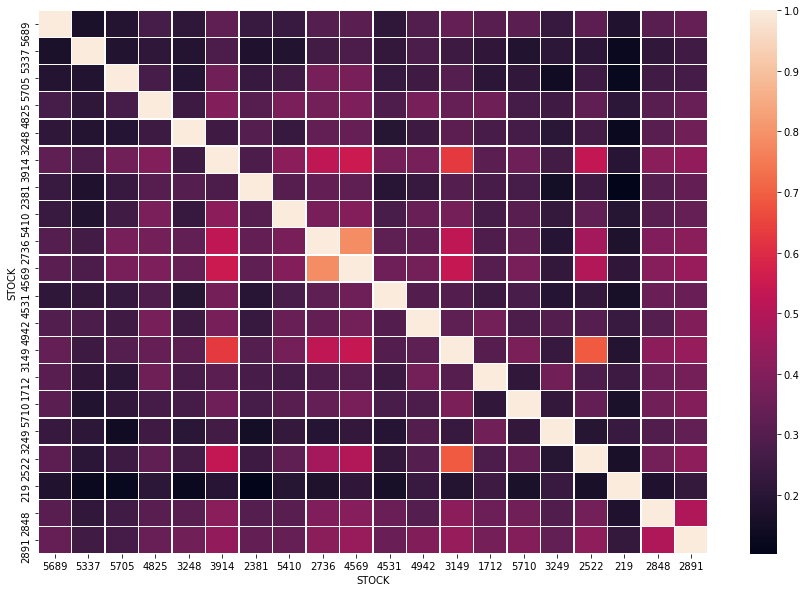

In [65]:
#Construction de la matrice de corrélation entre les différents actifs.
corr_actif=df_stock.transpose().corr()
fig,ax = plt.subplots(figsize=(15,10))  
sns.heatmap(corr_actif.iloc[:20,:20], annot=False, linewidths=.5, ax=ax) #On affiche uniquement les 20 premiers stocks.

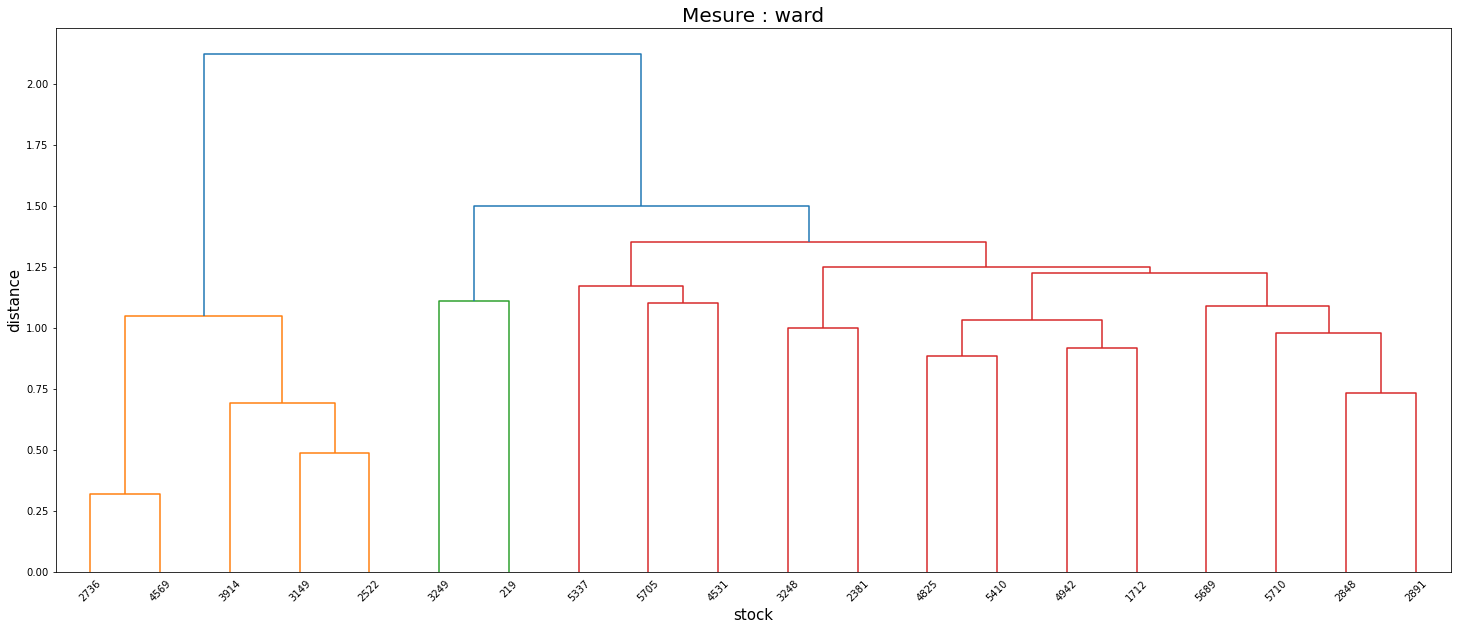

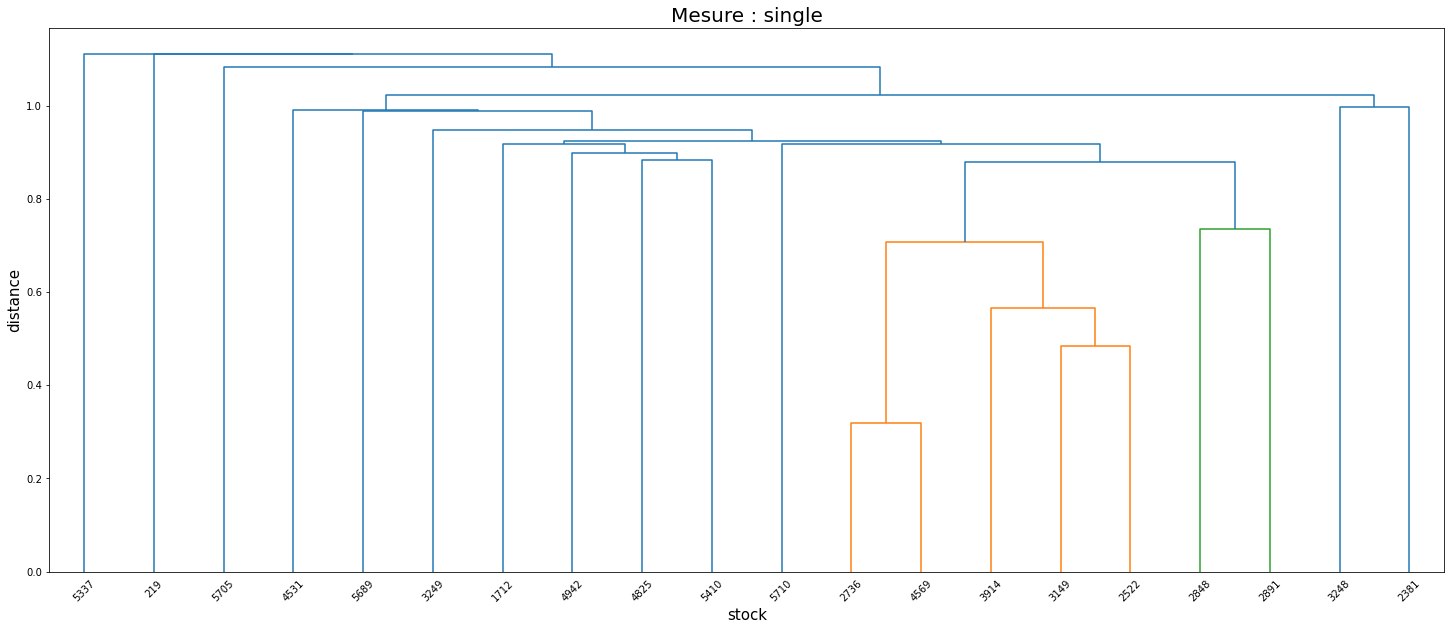

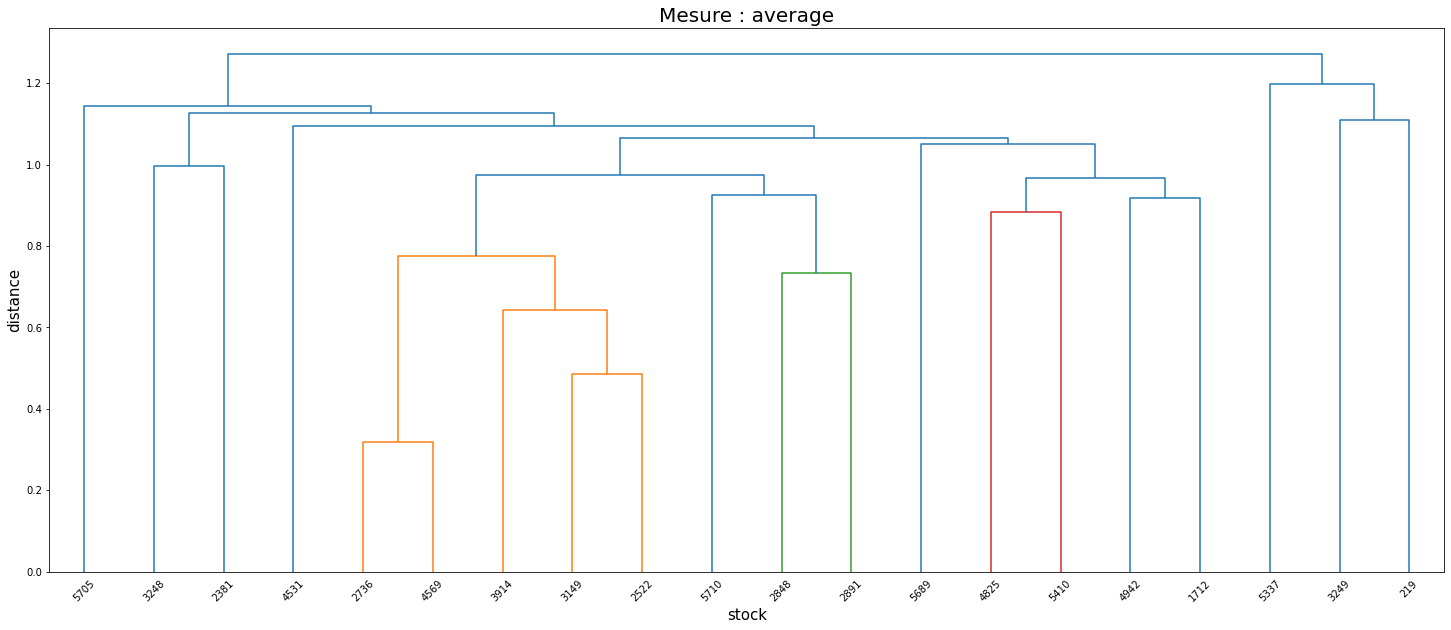

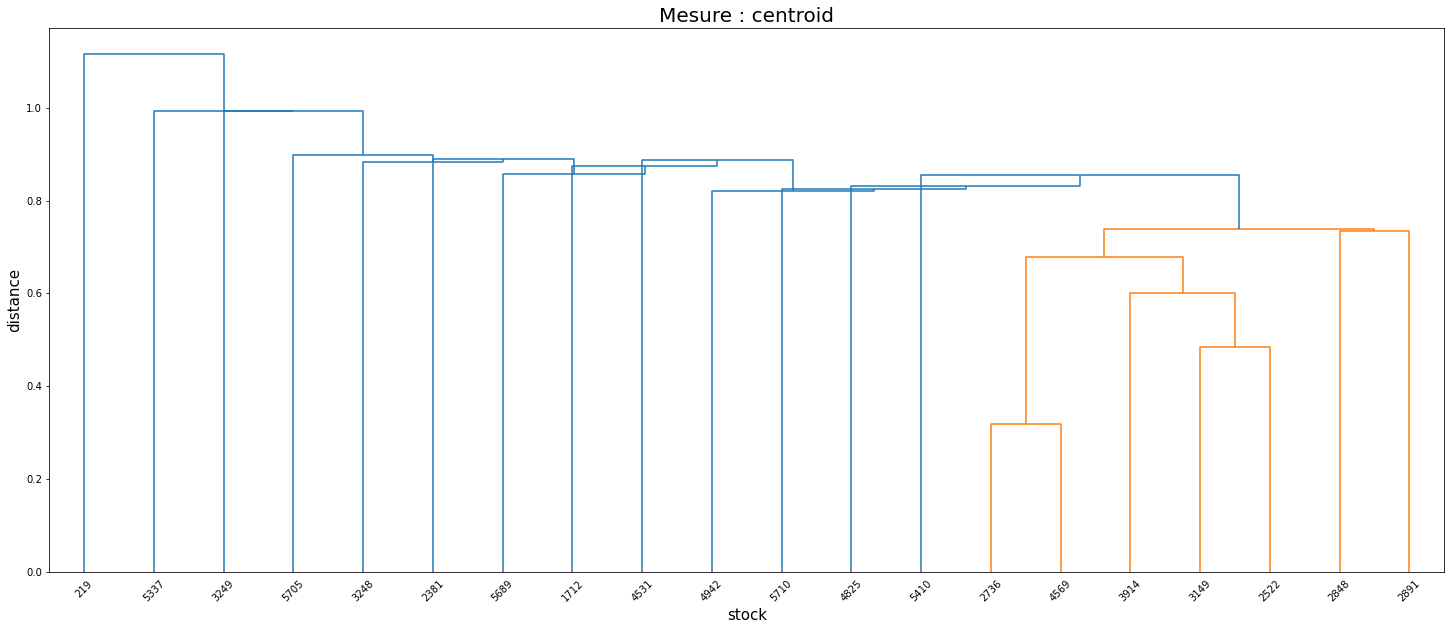

In [66]:
#Représentation avec 20 actifs et utilisation de différentes mesures

from scipy.cluster.hierarchy import dendrogram, linkage
Measurement=['ward','single','average','centroid']
for measure in Measurement:
    Z1 = linkage(corr_actif.iloc[:20,:20], measure)
    fig=plt.figure(figsize=(25,10))
    plt.title('Mesure : '+str(measure),fontsize=20)
    plt.xlabel('stock',fontsize=15)
    plt.ylabel('distance',fontsize=15)
    dendrogram(
        Z1,
        leaf_rotation=45.,  # rotation des abscisses
        leaf_font_size=10., 
        labels = corr_actif.iloc[:20,:20].columns
    )
    plt.show()

In [67]:
# Nous testons quelle mesure nous permet d'avoir le meilleur cluster. Pour ce faire nous utiliserons
#  le Cophenetic Correlation Coefficient. Plus il est poche de 1 et meilleure le cluster est.

Measurement=['ward','single','average','centroid','median','weighted']
print('Evaluation des clusters pour différentes métriques',end='\n\n')
for measure in Measurement:
    Z = linkage(corr_actif, measure)
    c, coph_dists = cophenet(Z, pdist(corr_actif))
    print(str(measure) + " : " + str(round(c,3)))

Evaluation des clusters pour différentes métriques

ward : 0.528
single : 0.409
average : 0.623
centroid : 0.632
median : 0.421
weighted : 0.549


In [68]:
#Affichage du nombre d'élément dans chaque cluster :
#Objectif : Identifier la métrique qui fait des groupes les plus homogène possible

from scipy.cluster.hierarchy import fcluster

mesures=['centroid','average','ward','weighted']
for mesure in mesures:
    Z = linkage(corr_actif, mesure)
    Clust=fcluster(Z, t=10, criterion='maxclust')
    print("Les clusters de la mesure :",mesure)
    print(pd.DataFrame(Clust).value_counts(),end='\n\n')

Les clusters de la mesure : centroid
6     542
10    290
4     140
7      52
8      35
5       6
9       4
1       4
3       3
2       1
dtype: int64

Les clusters de la mesure : average
7     293
10    280
3     216
4     134
6      55
8      46
9      43
5       5
1       4
2       1
dtype: int64

Les clusters de la mesure : ward
10    232
3     185
4     167
2     106
1      93
9      77
6      59
7      58
5      58
8      42
dtype: int64

Les clusters de la mesure : weighted
3     353
10    255
1     150
4     145
8      74
7      37
2      35
9      23
5       4
6       1
dtype: int64



Le clustering formé avec les métrique 'average','centroid' et'weighted' ne nous forme pas de groupes homogènes en taille. Nous souhaiterions disposé d'une meilleure répartition de nos actifs dans les clusters. La métrique "ward" bien que possédant une performance moindre nous permet d'avoir des groupes mieux répartis

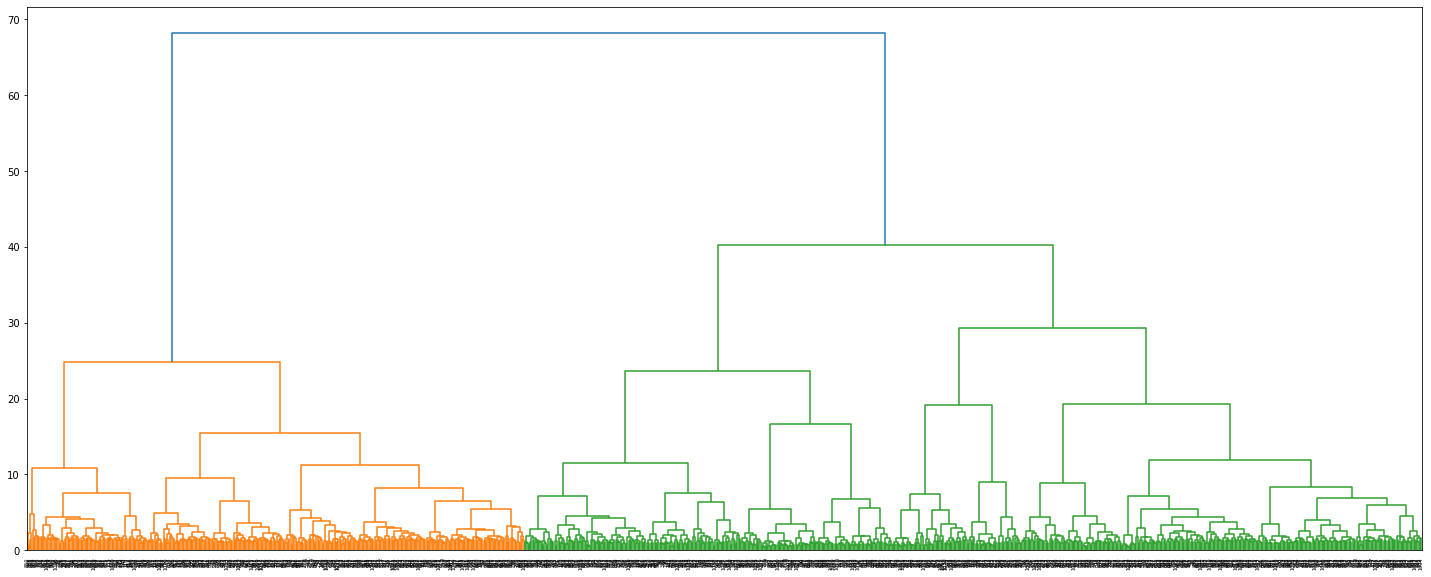

In [69]:
#Affichage des clusters pour la métrique choisis

Z = linkage(corr_actif, 'ward')
Clust=fcluster(Z, t=10, criterion='maxclust')
fig=plt.figure(figsize=(25,10))
dn=dendrogram(Z)

In [70]:
# Regrouper chaque actif dans son Cluster. 

CategorieClust=pd.DataFrame({'STOCK':Stocks_toujours_present,'Cluster_Category':Clust})
CategorieClust.set_index('STOCK',inplace=True)

#On stock les "noms" des clusters
ClustName=CategorieClust['Cluster_Category'].unique()

# On ajoute les catégories du clustering dans notre échantillon train
df_temp=trainClust.copy()
trainClust2=df_temp.merge(CategorieClust,left_on="STOCK",right_index=True)

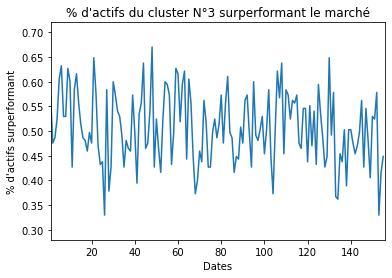

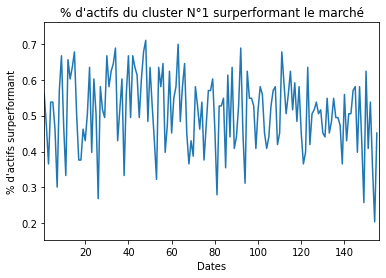

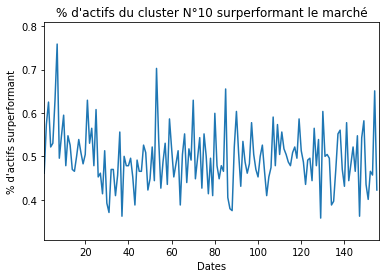

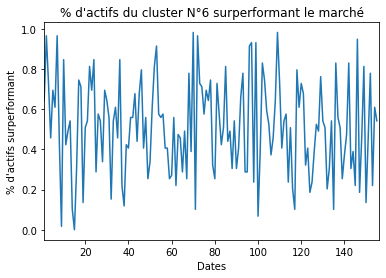

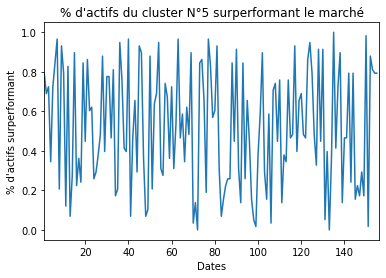

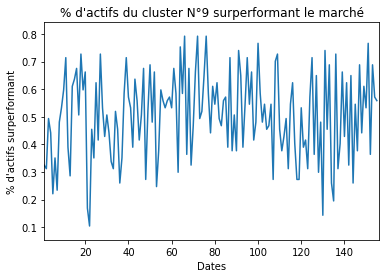

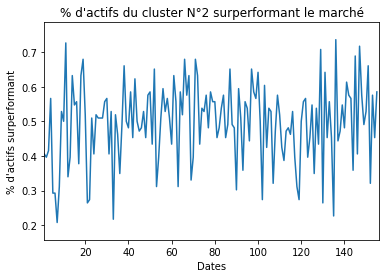

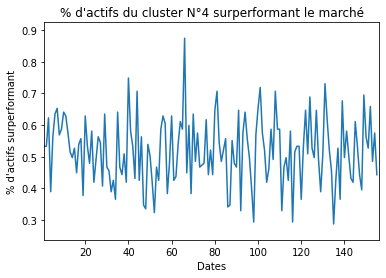

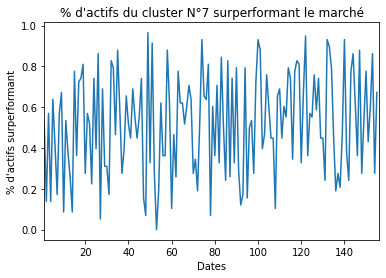

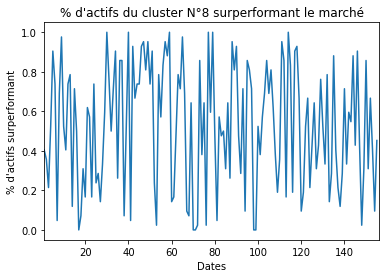

In [71]:
#Création d'un DataFrame pour stocker la proportion de la variable cible pour chaque cluster à chaque date
df_var_cible =pd.DataFrame(index=LesDates,columns=ClustName) 

for unclust in ClustName : # On parcourt tous les clusters
    for unedate in LesDates : #On parcourt l'ensemble des dates
        df_date_cluster=trainClust2[(trainClust2['DATE']==unedate) & (trainClust2['Cluster_Category']==unclust)]
        #testm[(testm['DATE']==LesDates[6])& (testm['Cluster_Category']==4)][target].value_counts()['True']
        #Gestion du cas où il n'y aurait que une seule valeur de la variable cible
        if len(df_date_cluster[target].value_counts(True)) > 1 :
            df_var_cible.loc[unedate,unclust]=df_date_cluster[target].value_counts(True).loc[True]
        elif df_date_cluster[target].value_counts(True).index[0]==False : #Que des Faux
            df_var_cible.loc[unedate,unclust]=0
        else: # Que des vrais
            df_var_cible.loc[unedate,unclust]=1

#On affiche pour chaque cluster, le % de surperformance dans le temps

for unclust in ClustName :
    plt.title("% d'actifs du cluster N°"+ str(unclust) +" surperformant le marché")
    plt.xlabel("Dates")
    plt.ylabel("% d'actifs surperformant")
    plt.plot(np.arange(1,nbdate+1),df_var_cible[unclust])
    plt.axis([1,nbdate+1,df_var_cible[unclust].min()-0.05,df_var_cible[unclust].max()+0.05])
    plt.show()

Les graphiques ci-dessus mettent en avant que les actifs d'un même cluster ont tendance à sous/surperformer le marché en même temps. En effet, pour un groupe d'actif n'ayant pas de comportement similaire, on aurait des courbes plus flat autour de 50%. L'absence de temporalité de nos dates ne nous permet pas d'observer des "tendances" boursiers où un cluster sur/sousperformerait le marché sur une période. 

Ces clusters seront rajoutés à nos modèles supervisés par la suite. On pourra alors juger de l'apport de nos catégories dans les performances.

In [72]:
trainClust2 

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_1_SUB_INDUSTRY_DATE_mean,VOLUME_1_SECTOR_DATE_mean,VOLUME_1_SECTOR_DATE_std,RET_1_SECTOR_DATE_std,VOLUME_mean_6_20,RET_mean_6_20,VOLUME_1_INDUSTRY_GROUP_DATE_mean,VOLUME_1_INDUSTRY_GROUP_DATE_std,RET_1_INDUSTRY_GROUP_DATE_std,Cluster_Category
ID,,,,,,,,,,,,,,,,,,,,,
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,0.014051,0.124151,1.605978,0.038375,-0.243615,-0.001078,-0.018206,1.358843,0.037538,9
2379,1,4,57,20,8,142,0.001780,-0.317288,0.016283,-0.294487,...,-0.001380,-0.030839,1.418442,0.022323,-0.103625,-0.005491,0.164844,1.811936,0.025836,9
5200,4,4,57,20,8,142,0.007280,-0.494664,0.021435,0.062093,...,0.007458,0.395458,12.455122,0.024492,0.053387,-0.002573,1.022761,18.187181,0.029036,9
8019,5,4,57,20,8,142,-0.009693,-0.133664,-0.004823,-0.118268,...,0.021678,0.307588,6.920716,0.035348,-0.386702,-0.001837,0.973222,10.435426,0.046651,9
10868,6,4,57,20,8,142,0.022801,-0.252580,0.000407,0.558520,...,0.008760,-0.081484,1.418050,0.033141,-0.040263,0.004580,-0.032918,1.778141,0.025995,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408286,214,5710,33,10,4,83,-0.003249,-0.128425,-0.011067,-0.212721,...,0.015464,-0.074600,0.706444,0.018533,0.599419,0.003173,0.054735,0.720541,0.020988,10
410731,218,5710,33,10,4,83,-0.035737,-0.448805,0.039491,0.768291,...,-0.012367,-0.005608,1.262971,0.020157,-0.474812,0.004007,-0.044732,1.154887,0.024330,10
413368,220,5710,33,10,4,83,-0.008788,NaN,-0.017028,NaN,...,0.003752,-0.106233,0.550191,0.022525,-0.434731,0.003108,-0.046217,0.713387,0.015102,10


In [73]:
# Sélection des features utilisées dans le modèle.
# Création de la nouvelle feature : Récupère la moyenne et l'écart-type du volume et des rendements
# de la veille par secteur

new_featuresClust = []
# Conditional aggregated features
shifts = [1]  # Choose some different shifts
statistics = ['mean']  # the type of stat
gb_features = ['Cluster_Category', 'DATE']
target_features = ['VOLUME','RET']
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        for target_feature in target_features :
            name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
            feat = f'{target_feature}_{shift}'
            new_featuresClust.append(name)
            for data in [trainClust2]:
                data[name] = data.groupby(gb_features)[feat].transform(stat)

# Ajout la moyenne de rendement et des volumes LT (de 6 à 20 jours)
n_shift_start=6
n_shifts_end = 20  # If you don't want all the shifts to reduce noise
for target_feature in target_features :
    features = [str(target_feature)+'_%d' % (i + 1) for i in range(n_shift_start,n_shifts_end)]
    name = f'{target_feature}_{"mean"}_{n_shift_start}_{n_shifts_end}'  
    new_features3.append(name)
    for data in [train, test]:
        data[name] = data[features].mean(axis=1)

In [74]:
featuresClust=new_featuresClust.copy()
featuresClust += ["RET"+'_%d' % (i + 1) for i in range(5)]
featuresClust += ["VOLUME"+'_%d' % (i + 1) for i in range(5)]
featuresClust+=['RET_1_SECTOR_DATE_mean','VOLUME_mean_6_20','RET_mean_6_20','VOLUME_1_SECTOR_DATE_mean']
featuresClust_Cat=['Cluster_Category'] #Feature catégorielle
featuresClust

['VOLUME_1_Cluster_Category_DATE_mean',
 'RET_1_Cluster_Category_DATE_mean',
 'RET_1',
 'RET_2',
 'RET_3',
 'RET_4',
 'RET_5',
 'VOLUME_1',
 'VOLUME_2',
 'VOLUME_3',
 'VOLUME_4',
 'VOLUME_5',
 'RET_1_SECTOR_DATE_mean',
 'VOLUME_mean_6_20',
 'RET_mean_6_20',
 'VOLUME_1_SECTOR_DATE_mean']

In [75]:
df_trainClust=trainClust2.copy()

# Séparation des données en train/test
trainR, testR = train_test_split(df_trainClust, test_size=0.2, random_state = 42)
X_train_clust=trainR[featuresClust+featuresClust_Cat]
y_train_clust=trainR[target]
X_test_clust=testR[featuresClust+featuresClust_Cat]
y_test_clust=testR[target]

In [76]:
#Mise en place d'un simple AdaBoostClassifier

from sklearn.ensemble import AdaBoostClassifier
start_time=time.time()

numeric_transformer = Pipeline(steps=[
                                    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
                                    ('scaler', StandardScaler())])

# Transformation des features catégorielles :

categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

preproc = ColumnTransformer(transformers=[("num", numeric_transformer, featuresClust),
                                          ("cat", categorical_transformer, featuresClust_Cat)])

clf_ada = AdaBoostClassifier(n_estimators=10)
pipe_ada = Pipeline(steps=[('preprocessor', preproc),
                       ("clf_ada",clf_ada)])

pipe_ada.fit(X_train_clust,y_train_clust)
print("Accuracy sur l'échantillon de train :",pipe_ada.score(X_train_clust,y_train_clust))
y_pred_clust=pipe_ada.predict(X_test_clust)
print("Accuracy sur l'échantillon de test :",accuracy_score(y_pred_clust,y_test_clust))

Accuracy sur l'échantillon de train : 0.5233099709467757
Accuracy sur l'échantillon de test : 0.5229879893371672


Nous allons à présent sélectionner nos paramètres pour le AdaBoostClassfier. Les paramètres qui seront amenés à varier sont :
* learning_rate ;
* n_estimators ;
* base_estimator__max_depth : qui correpond à la profondeur maximal de notre Arbre de Décision (le weaklearner)
* base_estimator__min_samples_leaf

### Attention code LONG

In [77]:
# Optimisation des paramètres du AdaBoost :learning_rate, n_estimator ainsi que les pram

models = [("ada", AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]

#Paramétrage des weaklearner 


#Ajout des paramètres que nous souhaitons faire varier

grids = {"ada" : {'ada__n_estimators': [50,100,150],
                  'ada__learning_rate' :[0.3,0.5,1.0],
                  'ada__base_estimator__max_depth':[i for i in range(1,6,2)], #Pour atteindre les paramètres du WL
                  'ada__base_estimator__min_samples_leaf' :[0.05,0.1]} 
        }

numeric_transformer = Pipeline(steps=[
                                    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
                                    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

preproc = ColumnTransformer(transformers=[("num", numeric_transformer, featuresClust),
                                          ("cat", categorical_transformer, featuresClust_Cat)])

crossval=3
modelsOpt=[]

for name, model in models:
    start_time = time.time()
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=crossval,n_jobs=-1)
    clf.fit(X_train_clust, y_train_clust)
    y_pred_clust=clf.predict(X_test_clust) #On récupère la prédiction sur la base de test
    score_test=accuracy_score(y_pred_clust, y_test_clust)
    modelsOpt.append(clf) #On stock le modèle optimal
    print('Résultat pour : {}'.format(name))
    print('Hyper-paramètres: {}'.format(clf.best_params_))
    print('Meilleur accuracy sur train (crossval) est: {}'.format(clf.best_score_))
    print('Accuracy sur test est: {}'.format(score_test))
    cprint("--------- %s secondes ---------" % (round(time.time() - start_time,2)), 'red')
    print('-----------------------------------------------------')

Résultat pour : ada
Hyper-paramètres: {'ada__base_estimator__max_depth': 5, 'ada__base_estimator__min_samples_leaf': 0.05, 'ada__learning_rate': 0.5, 'ada__n_estimators': 150}
Meilleur accuracy sur train (crossval) est: 0.570049719950879
Accuracy sur test est: 0.5775301764159703
--------- 2801.67 secondes ---------
-----------------------------------------------------


Accuracy sur la base de train : 0.607
Matrice de confusion base train :


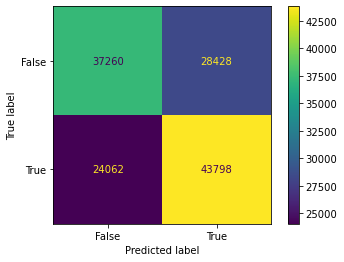

In [78]:
# Affichage de la matrice de confusion sur notre base test :
print('Accuracy sur la base de train :',round(clf.score(X_train_clust, y_train_clust),3))
print("Matrice de confusion base train :")
plot_confusion_matrix(clf, X_train_clust, y_train_clust, values_format = '')

Accuracy sur la base de train : 0.578
Matrice de confusion base test


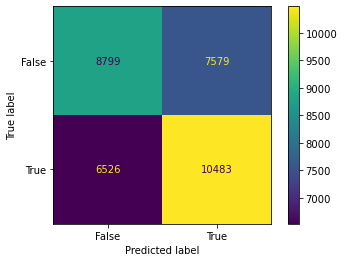

In [79]:
print('Accuracy sur la base de train :',round(clf.score(X_test_clust, y_test_clust),3))
print("Matrice de confusion base test")
plot_confusion_matrix(clf, X_test_clust, y_test_clust, values_format = '')

Les résultats obtenus avec notre dernière méthode sont très satisfaisant. L'ajout des catégories avec le clustering nous permet d'améliorer nos résultats. L'accuracy moyenne de notre cross-validation est de 57%, nous obtenons des résultats semblables sur notre base de test.

In [82]:
#On récupère les hyper-paramètres du modèles : Utile notament si on veut utiliser la prédiction avec
# predict_proba car GridSearch n'a pas cette propriété.

ada_boo_opt=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=modelsOpt[0].best_params_['ada__base_estimator__max_depth'],\
                                                                    min_samples_leaf=modelsOpt[0].best_params_['ada__base_estimator__min_samples_leaf']),
                               learning_rate=modelsOpt[0].best_params_['ada__learning_rate'],
                               n_estimators =modelsOpt[0].best_params_['ada__n_estimators'])
                               
pipe_ada_opt = Pipeline(steps=[('preprocessor', preproc),
                       ("ada_boo_opt",ada_boo_opt)])

## Sélection du modèle finale

Au vu des différents résultats obtenus précédemment nous choisisson de mettre en place le modèle AdaBoost sur les actifs présent à toutes les dates et en parallèle la fôret aléatoire optimisée dans la partie du VotingClassifier pour le reste des stocks. Les résultats obtenus avec un prédiction direct nous semble plus intéressant que la méthode utilisée par QRT en comparant les probas prédites à la médiane des prédictions à la même date.

Nous allons donc : 
* Séparer la base de test du challenge en 2 : Actifs présent à toutes les dates et les autres.
* Pour chaque échantillon on récupère les features utilisées dans chaqun de nos sous-modèles (groupe du cluster,
* Prédictions
* Regroupement des estimations dans une seule base. Utilisation de l'ordre des index pour le regroupement.

In [170]:
#Séparation de l'échantillon de test

testcopy=test.copy()
print(" Le fichier de test comporte :",testcopy.shape[0],' lignes')
testClust=testcopy[testcopy['STOCK'].isin(Stocks_toujours_present)]
print(" Le fichier de test Clust comporte :",testClust.shape[0],' lignes')

#Attention des nouveaux stocks sont présent alors nous n'utilisons pas la liste "Stock_pastoujours_present"
testNonClust=testcopy[testcopy['STOCK'].isin(Stocks_toujours_present)==False]
print(" Le fichier de test Non Clust comporte :",testNonClust.shape[0],' lignes')

verif=testcopy.shape[0]-testClust.shape[0]-testNonClust.shape[0]
print(" La somme des 2 sous échantillons est égale à l'échantillon train :", verif==0)

 Le fichier de test comporte : 198429  lignes
 Le fichier de test Clust comporte : 72550  lignes
 Le fichier de test Non Clust comporte : 125879  lignes
La somme des 2 sous échantillons est égale à l'échantillon train : True


In [171]:
testClust.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_1_INDUSTRY_GROUP_DATE_mean,RET_1_SUB_INDUSTRY_DATE_mean,VOLUME_1_SECTOR_DATE_mean,VOLUME_1_SECTOR_DATE_std,RET_1_SECTOR_DATE_std,VOLUME_mean_6_20,RET_mean_6_20,VOLUME_1_INDUSTRY_GROUP_DATE_mean,VOLUME_1_INDUSTRY_GROUP_DATE_std,RET_1_INDUSTRY_GROUP_DATE_std
ID,,,,,,,,,,,,,,,,,,,,,
418597,2,4,57,20,8,142,0.005008,-0.115845,0.005914,-0.107441,...,0.003568,0.002386,-0.159531,0.589200,0.019487,-0.054576,0.000502,-0.154350,0.541159,0.014697
418600,2,8,1,1,1,2,-0.009318,-0.499762,0.030839,-0.250631,...,-0.000421,-0.000876,-0.242262,0.588257,0.017618,0.075539,-0.006193,-0.242262,0.588257,0.017618
418631,2,45,52,18,7,121,0.003338,-0.403139,0.007688,-0.438001,...,0.001944,0.003192,-0.011474,1.183101,0.011532,-0.119708,-0.002078,-0.003675,0.617790,0.009769
418643,2,59,57,20,8,143,0.014744,-0.168469,0.014964,-0.202761,...,0.003568,0.010162,-0.159531,0.589200,0.019487,-0.206184,0.001613,-0.154350,0.541159,0.014697
418645,2,65,56,20,8,139,0.000185,-0.079187,0.010432,-0.387234,...,0.003568,0.001220,-0.159531,0.589200,0.019487,0.046548,0.001404,-0.154350,0.541159,0.014697


In [114]:
#Ajout des catégories de cluster et les features conditionnelles

df_temp=testClust.copy()
testClust2=df_temp.merge(CategorieClust,left_on="STOCK",right_index=True)

shifts = [1]  # Choose some different shifts
statistics = ['mean']  # the type of stat
gb_features = ['Cluster_Category', 'DATE']
target_features = ['VOLUME','RET']
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        for target_feature in target_features :
            name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
            feat = f'{target_feature}_{shift}'
            for data in [testClust2]:
                data[name] = data.groupby(gb_features)[feat].transform(stat)

In [157]:
X_res_clust=testClust2[featuresClust+featuresClust_Cat]
X_res_clust.head()

,VOLUME_1_Cluster_Category_DATE_mean,RET_1_Cluster_Category_DATE_mean,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,RET_1_SECTOR_DATE_mean,VOLUME_mean_6_20,RET_mean_6_20,VOLUME_1_SECTOR_DATE_mean,Cluster_Category
ID,,,,,,,,,,,,,,,,,
418597,-0.127442,-0.000956,0.005008,0.005914,-0.003927,0.000873,-0.086193,-0.115845,-0.107441,0.347900,0.731513,2.681007,-0.000866,-0.054576,0.000502,-0.159531,9
421426,-0.164775,0.009741,0.016708,0.014059,0.021732,-0.019502,0.004352,-0.041409,-0.175019,0.095310,-0.509642,-0.282151,0.013119,0.184604,0.002830,-0.081771,9
424434,-0.088271,0.000690,-0.000463,0.025832,0.004778,0.000318,-0.006488,-0.026826,-0.101962,0.432644,0.718386,-0.209850,0.002570,-0.135689,-0.002863,-0.048173,9
427429,-0.074371,-0.007529,0.002851,-0.001708,0.002976,0.005415,-0.006512,-0.334000,-0.032465,-0.125112,0.202480,0.685588,-0.000990,-0.168786,0.001131,-0.183522,9
430372,-0.115650,-0.028494,-0.026166,-0.014575,-0.043432,-0.001606,0.014634,0.042963,-0.164021,-0.142686,-0.196702,-0.022248,-0.018747,0.029352,0.001899,-0.167527,9


In [118]:
#Prédiction de la partie CLustering : modèle est resté en mémoire dans modelsOpt

y_pred_clustF=modelsOpt[0].predict(X_res_clust)

In [138]:
# pour la partie non clustering. Le modèle n'est plus en mémoire : on fit sur le train des stocks qui ne sont pas pris en compte dans le clustering

X_train_forest=trainOut[features3]
y_train_forest=trainOut[target]

numeric_transformer = Pipeline(steps=[
                                    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
                                    ('scaler', StandardScaler())])

preproc = ColumnTransformer(transformers=[("num", numeric_transformer, features3)])
pipe_rdm_frt_resul = Pipeline(steps=[('preprocessor', preproc), ('rdm_frt_opt', rdm_frt_opt)])
pipe_rdm_frt_resul.fit(X_train_forest, y_train_forest)
print('---------RandomForestClassifier---------')
print('Score sur la base de train :',round(pipe_rdm_frt_resul.score(X_train_forest, y_train_forest),3))

---------RandomForestClassifier---------
Score sur la base de train : 0.5400603701580607


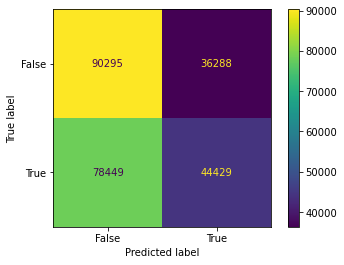

In [143]:
plot_confusion_matrix(pipe_rdm_frt_resul, X_train_forest, y_train_forest, values_format = '')

In [172]:
# Prédiction

X_res_Nonclust=testNonClust[features3]
y_pred_NonclustF=pipe_rdm_frt_resul.predict(X_res_Nonclust)

In [208]:
pd.DataFrame(y_pred_NonclustF).value_counts()

False    85022
True     40857
dtype: int64

In [181]:
# On regroupe avec les index "ID"

df_pred_clust=X_res_clust.copy()
df_pred_clust['pred']=y_pred_clustF
df_pred_clust['pred']

df_pred_Nonclust=X_res_Nonclust.copy()
df_pred_Nonclust['pred']=y_pred_NonclustF
df_pred_Nonclust['pred']

ID
418595    False
418596    False
418598     True
418599    False
418601    False
          ...  
617018     True
617019    False
617021    False
617022    False
617023    False
Name: pred, Length: 125879, dtype: bool

In [200]:
concat_pred=pd.concat([df_pred_Nonclust['pred'], df_pred_clust['pred']])
submission = pd.Series(concat_pred)
submission.index = test.index
submission.name = target
submission

In [204]:
submission.to_csv('./submission_qrt.csv', index=True, header=True)

#### Résultats avec predict_proba

In [209]:
# On re-entraine notre modèle pour les actifs du clustering pour enlever GridSearch et pouvoir récupérer predict_proba
pipe_ada_opt.fit(X_train_clust, y_train_clust)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['VOLUME_1_Cluster_Category_DATE_mean',
                                                   'RET_1_Cluster_Category_DATE_mean',
                                                   'RET_1', 'RET_2', 'RET_3',
                                                   'RET_4', 'RET_5', 'VOLUME_1',
                                                   'VOLUME_2', 'VOLUME_3',
                                                   'VOLUM

In [243]:
pipe_ada_opt.score(X_train_clust, y_train_clust)

0.606957797945308

In [238]:
pred_proba_clust=pipe_ada_opt.predict_proba(X_res_clust)
pred_proba_Nonclust=pipe_rdm_frt_resul.predict_proba(X_res_Nonclust)

#On regarde dans quel ordre sont les probas. On veut les proba True
print("Non Clust proba N°1 ",df_pred_Nonclust['pred'].value_counts().index[0])
print("Clust proba N°1 ",df_pred_clust['pred'].value_counts().index[0])

Non Clust proba N°1  False
Clust proba N°1  True


In [239]:
df_pred_proba_clust=X_res_clust.copy()
df_pred_proba_clust['pred']=pred_proba_clust[:, 0]


df_pred_proba_Nonclust=X_res_Nonclust.copy()
df_pred_proba_Nonclust['pred']=pred_proba_Nonclust[:, 1]

concat_pred_proba=pd.concat([df_pred_proba_Nonclust['pred'], df_pred_proba_clust['pred']])

sub=test.merge(concat_pred_proba,left_index=True,right_index=True)
y_pred_proba_submission = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submissionProba = pd.Series(y_pred_proba_submission)
submissionProba.index = test.index
submissionProba.name = target

submissionProba.to_csv('./submissionProba_qrt.csv', index=True, header=True)

Les résultats obtenus sont décevants. Aux alentours de 50.5%. La concaténation de 2 méthodes nous pénalise peut-être ... Certainement un overfitting présent dans les deux méthodes. Notre Forêt aléatoire a tendance a prédire plus souvent False et notre modèle sur les actifs clust a un score de 0.6 lorsque nous entraînons à nouveau sur l'ensemble des données clust afin de soumettre nos résultats avec Predict_Proba. Malgré la faiblesse de nos résultats, nous ne tenterons pas d'améliorer ceux là pour cause de manque de temps et d'algorithmes relativement longs.

Les principales difficultés rencontrées :
* La prédiction avec les probabilités rapportés aux dates
* L'utilisation de GridSearch : temps d'éxécution lents, résultat de l'accuracy sur la cross-val bonne mais overfitting (notamment KNN).
* Anonymisation des données : 
    * rendant plus difficile l'analyse quand les secteurs, dates et autres données qualitatives sont non connues
    * rendant l'exploitation de la temporalité difficile notamment dans la partie clustering.